# EDA and Cleaning

[data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

# pythonize columns
train.columns = [x.lower().replace(' ','_').replace('/','_') for x in train.columns]
test.columns = [x.lower().replace(' ','_').replace('/','_') for x in test.columns]

# drop id and set pid as index
train.set_index('pid', inplace = True)
train.drop('id', axis = 1, inplace = True)

test.set_index('pid', inplace = True)
test.drop('id', axis = 1, inplace = True)

In [3]:
train.shape

(2051, 79)

In [4]:
train.columns

Index(['ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config',
       'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod_add', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air',
       'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual',
       'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu',
       'garage_type', 'garage_yr_blt', 'garage_finish', 'gara

## Review target column

In [5]:
train.saleprice.describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: saleprice, dtype: float64

In [6]:
saleprice_mean = train.saleprice.describe()['mean']
saleprice_std = train.saleprice.describe()['std']

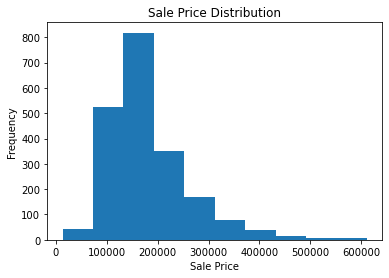

In [7]:
# plot it
plt.hist(train.saleprice)
plt.title('Sale Price Distribution')
plt.xlabel('Sale Price')
plt.ylabel('Frequency');

## Review Data and Individual Columns for Outliers, etc.

###  Cols [0,10] --> [0,5] after cleaning

In [8]:
train.dtypes[:10]

ms_subclass       int64
ms_zoning        object
lot_frontage    float64
lot_area          int64
street           object
alley            object
lot_shape        object
land_contour     object
utilities        object
lot_config       object
dtype: object

**Observations**
  *  `ms_subclass` should be an object so we don't lose leading zeroes

In [9]:
# check for nulls
train.isnull().sum()[:10]

ms_subclass        0
ms_zoning          0
lot_frontage     330
lot_area           0
street             0
alley           1911
lot_shape          0
land_contour       0
utilities          0
lot_config         0
dtype: int64

In [10]:
test.isnull().sum()[:10]

ms_subclass       0
ms_zoning         0
lot_frontage    160
lot_area          0
street            0
alley           820
lot_shape         0
land_contour      0
utilities         0
lot_config        0
dtype: int64

**Observations**
1. `alley` has 1911 nulls out of 2051 records. Consider turning this into a dummy for alley or no alley
2. `lot_frontage` has 16% null coverage .. possibly due to apartments?
3. Everything else looks good!

#### Address `lot_frontage` nulls

In [11]:
train.lot_frontage.describe()

count    1721.000000
mean       69.055200
std        23.260653
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: lot_frontage, dtype: float64

In [12]:
# impute lot_frontage with the mean
lot_frontage_mean = train.lot_frontage.describe()['mean']

train.lot_frontage = train.lot_frontage.map(lambda x: lot_frontage_mean if pd.isnull(x) else x)
test.lot_frontage = test.lot_frontage.map(lambda x: lot_frontage_mean if pd.isnull(x) else x)

train.lot_frontage.describe()

count    2051.000000
mean       69.055200
std        21.306357
min        21.000000
25%        60.000000
50%        69.055200
75%        78.000000
max       313.000000
Name: lot_frontage, dtype: float64

#### Address `alley` nulls

In [13]:
# review alley
train.alley.unique()

train.alley.map(lambda x: 0 if pd.isnull(x) else x).value_counts(normalize=True)

0       0.931741
Grvl    0.041443
Pave    0.026816
Name: alley, dtype: float64

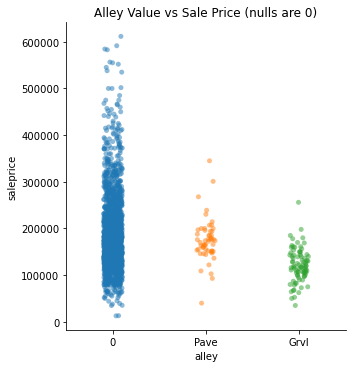

In [14]:
sns.catplot(x="alley", y="saleprice", data=pd.DataFrame(train.alley.map(lambda x: 0 if pd.isnull(x) else x))\
            .join(train.saleprice),
             alpha = 0.5)\
    .set(title = 'Alley Value vs Sale Price (nulls are 0)');


**Observation**: Alley vs no-alley could be a good indicator

In [15]:
# update alley to has_alley
train.alley = train.alley.map(lambda x: 0 if pd.isnull(x) else 1)
test.alley = test.alley.map(lambda x: 0 if pd.isnull(x) else 1)

train.rename(columns = {'alley': 'has_alley'}, inplace = True)  
test.rename(columns = {'alley': 'has_alley'}, inplace = True) 

train.head().iloc[[],0:10]

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,has_alley,lot_shape,land_contour,utilities,lot_config
pid,,,,,,,,,,


#### review `ms_subclass`

In [16]:
# add 0 and make a string
train.ms_subclass = ['0' + str(i) if len(str(i)) == 2 else str(i) for i in train.ms_subclass]
test.ms_subclass = ['0' + str(i) if len(str(i)) == 2 else str(i) for i in test.ms_subclass]

train.ms_subclass.unique()

array(['060', '020', '050', '180', '160', '070', '120', '190', '085',
       '030', '090', '080', '075', '045', '040', '150'], dtype=object)

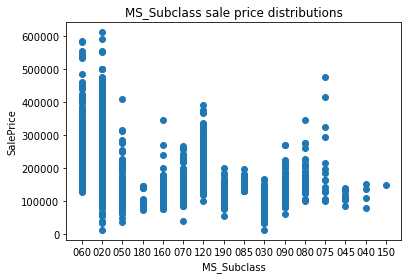

In [17]:
# see distribution for ms_subclass
plt.scatter(train.ms_subclass, train.saleprice)
plt.title('MS_Subclass sale price distributions')
plt.xlabel('MS_Subclass')
plt.ylabel('SalePrice');

**Observation** group these by saleprice mean into a few groups

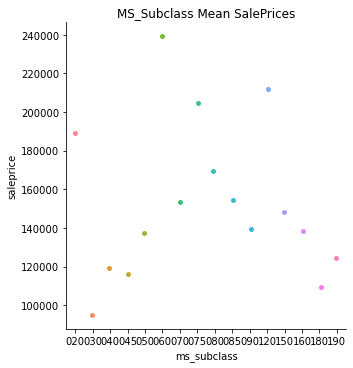

In [18]:
# review means of saleprice by ms_subclass
sns.catplot(x='ms_subclass', y = 'saleprice', data = pd.DataFrame(train.groupby('ms_subclass').mean().saleprice).reset_index())\
    .set(title = 'MS_Subclass Mean SalePrices');

**Observation**: Because of the wide range of values, separate into 4 bands:
  *  1 std deviation away negative
  *  \[1,0) std deviations away
  *  \[0,1) std deviations away
  *  1 std deviation away positive

In [19]:
ms_subclass_train = pd.DataFrame(train.ms_subclass.map(train.groupby('ms_subclass').mean().\
                                              saleprice.map(lambda x: 0 if x < saleprice_mean - saleprice_std\
                                                          else 1 if x < saleprice_mean\
                                                          else 2 if x <= saleprice_mean + saleprice_std
                                                          else 3 if x > saleprice_mean + saleprice_std
                                                          else np.nan)))
ms_subclass_test = pd.DataFrame(test.ms_subclass.map(train.groupby('ms_subclass').mean()\
                                            .saleprice.map(lambda x: 0 if x < saleprice_mean - saleprice_std\
                                                                  else 1 if x < saleprice_mean\
                                                                  else 2 if x <= saleprice_mean + saleprice_std
                                                                  else 3 if x > saleprice_mean + saleprice_std
                                                                  else np.nan)))
        






ms_subclass_train.rename(columns = {'ms_subclass': 'ms_subclass_id'}, inplace=True)
ms_subclass_test.rename(columns = {'ms_subclass': 'ms_subclass_id'}, inplace=True)

ms_subclass_train= ms_subclass_train.join(train[['ms_subclass', 'saleprice']])

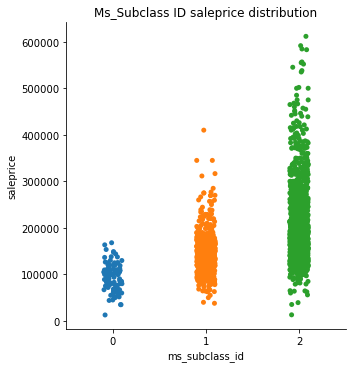

In [20]:
sns.catplot(x = 'ms_subclass_id', y='saleprice', data = ms_subclass_train)\
    .set(title = 'Ms_Subclass ID saleprice distribution');

**Observation**
  *  Split appears to be working as intended, add to train dataframe

In [21]:
train.shape

(2051, 79)

In [22]:
train = pd.merge(train,
             ms_subclass_train[['ms_subclass_id']],
             left_index = True,
             right_index = True)

In [23]:
# confirm merge only added one column
train.shape

(2051, 80)

In [24]:
# repeate process for test
test.shape

(878, 78)

In [25]:
test = pd.merge(test,
              ms_subclass_test[['ms_subclass_id']],
             left_index = True,
             right_index = True)

In [26]:
test.shape

(878, 79)

In [27]:
# rename ms_subclass_id
train.rename(columns = {'ms_subclass_id': 'ms_subclass_group'}, inplace=True)
test.rename(columns = {'ms_subclass_id': 'ms_subclass_group'}, inplace=True)


train.head().iloc[:,-5:]

,mo_sold,yr_sold,sale_type,saleprice,ms_subclass_group
pid,,,,,
533352170,3,2010,WD,130500,2
531379050,4,2009,WD,220000,2
535304180,1,2010,WD,109000,2
916386060,4,2010,WD,174000,2
906425045,3,2010,WD,138500,1


In [28]:
# now we can dummy by ms_subclass_group
train = train.join(pd.get_dummies(train.ms_subclass_group, prefix = 'ms_subclass_group')\
                   .loc[:,['ms_subclass_group_1','ms_subclass_group_2']])
test = test.join(pd.get_dummies(test.ms_subclass_group, prefix = 'ms_subclass_group')\
                   .loc[:,['ms_subclass_group_1','ms_subclass_group_2']])


train.iloc[[],-5:]

,sale_type,saleprice,ms_subclass_group,ms_subclass_group_1,ms_subclass_group_2
pid,,,,,


In [29]:
# drop neighborhood, neighborhood_group
train.drop(['ms_subclass','ms_subclass_group'], axis=1, inplace = True)
test.drop(['ms_subclass','ms_subclass_group'], axis=1, inplace = True)

train.iloc[[],5:15]


,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style
pid,,,,,,,,,,


#### review `ms_zoning`

In [30]:
train.ms_zoning.unique()

array(['RL', 'RM', 'FV', 'C (all)', 'A (agr)', 'RH', 'I (all)'],
      dtype=object)

In [31]:
# update C A and I to represent their zones from data dict
train.ms_zoning = train.ms_zoning.apply(lambda x: x[0] if len(x)>2 else x)
test.ms_zoning = test.ms_zoning.apply(lambda x: x[0] if len(x)>2 else x)

train.ms_zoning.unique()

array(['RL', 'RM', 'FV', 'C', 'A', 'RH', 'I'], dtype=object)

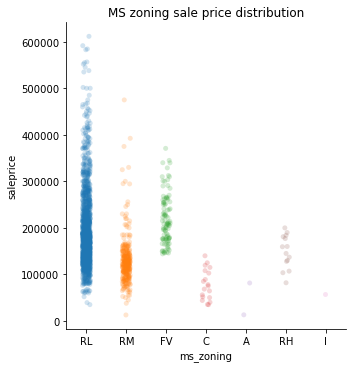

In [32]:
# see dispersion
sns.catplot(x = 'ms_zoning', y='saleprice', data = train, alpha = 0.2)\
    .set(title = 'MS zoning sale price distribution');

In [33]:
train.ms_zoning.value_counts(normalize=True)

RL    0.779132
RM    0.154071
FV    0.049244
C     0.009264
RH    0.006826
A     0.000975
I     0.000488
Name: ms_zoning, dtype: float64

In [34]:
# dummy RL and FV
train = train.join(pd.get_dummies(train.ms_zoning, prefix = 'ms_zoning')\
                   .loc[:,['ms_zoning_RL','ms_zoning_FV']])
test = test.join(pd.get_dummies(test.ms_zoning, prefix = 'ms_zoning')\
                   .loc[:,['ms_zoning_RL','ms_zoning_FV']])


train.head().iloc[[],-5:]

,saleprice,ms_subclass_group_1,ms_subclass_group_2,ms_zoning_RL,ms_zoning_FV
pid,,,,,


In [35]:
# drop ms_zoning
train.drop('ms_zoning', axis=1, inplace=True)
test.drop('ms_zoning', axis=1, inplace=True)


train.head().iloc[[],0:10]

,lot_frontage,lot_area,street,has_alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood
pid,,,,,,,,,,


#### review `lot_frontage`

In [36]:
train.lot_frontage.describe()

count    2051.000000
mean       69.055200
std        21.306357
min        21.000000
25%        60.000000
50%        69.055200
75%        78.000000
max       313.000000
Name: lot_frontage, dtype: float64

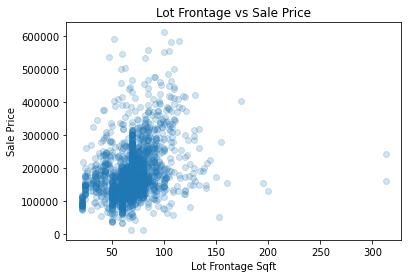

In [37]:
# plot lot_frontage
plt.scatter(train.lot_frontage, train.saleprice, alpha=0.2)
plt.title('Lot Frontage vs Sale Price')
plt.xlabel('Lot Frontage Sqft')
plt.ylabel('Sale Price');

In [38]:
# drop two big outliers
train = train[train.lot_frontage < 250]
train.lot_area.describe()

count      2049.000000
mean      10030.358712
std        6628.642593
min        1300.000000
25%        7500.000000
50%        9405.000000
75%       11500.000000
max      159000.000000
Name: lot_area, dtype: float64

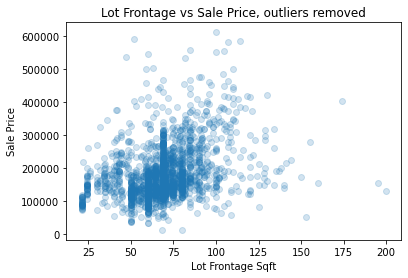

In [39]:
# plot lot_frontage
plt.scatter(train.lot_frontage, train.saleprice, alpha=0.2)
plt.title('Lot Frontage vs Sale Price, outliers removed')
plt.xlabel('Lot Frontage Sqft')
plt.ylabel('Sale Price');

#### review `lot_area`

In [40]:
train.lot_area.describe()

count      2049.000000
mean      10030.358712
std        6628.642593
min        1300.000000
25%        7500.000000
50%        9405.000000
75%       11500.000000
max      159000.000000
Name: lot_area, dtype: float64

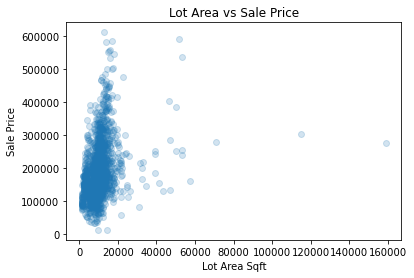

In [41]:
# plot lot_area
plt.scatter(train.lot_area, train.saleprice, alpha = 0.2)
plt.title('Lot Area vs Sale Price')
plt.xlabel('Lot Area Sqft')
plt.ylabel('Sale Price');

In [42]:
# drop two big outliers
train = train[train.lot_area < 80_000]
train.lot_area.describe()

count     2047.000000
mean      9906.231558
std       5264.901142
min       1300.000000
25%       7500.000000
50%       9400.000000
75%      11500.000000
max      70761.000000
Name: lot_area, dtype: float64

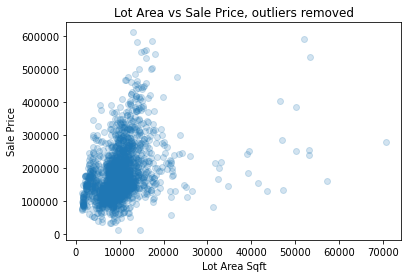

In [43]:
# plot lot_area
plt.scatter(train.lot_area, train.saleprice, alpha = 0.2)
plt.title('Lot Area vs Sale Price, outliers removed')
plt.xlabel('Lot Area Sqft')
plt.ylabel('Sale Price');

**Observation** More outliers may need to be dropped

#### review `street`

In [44]:
train.street.unique()

array(['Pave', 'Grvl'], dtype=object)

**Observation**
only .3% of data set is not gravel, drop column

In [45]:
train.drop('street', axis=1, inplace=True)
test.drop('street', axis=1, inplace=True)

train.iloc[[],:10]

,lot_frontage,lot_area,has_alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1
pid,,,,,,,,,,


#### review `lot_shape`

In [46]:
train.lot_shape.value_counts(normalize = True)

Reg    0.632633
IR1    0.338056
IR2    0.025403
IR3    0.003908
Name: lot_shape, dtype: float64

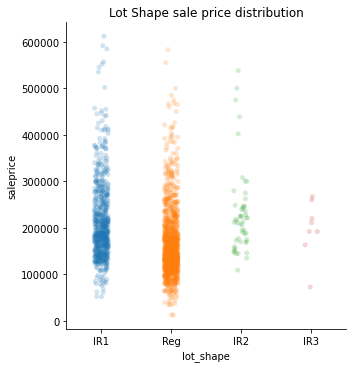

In [47]:
sns.catplot(x = 'lot_shape', y='saleprice', data=train, alpha = 0.2)\
    .set(title = 'Lot Shape sale price distribution');

In [48]:
train.groupby('lot_shape').mean().saleprice

lot_shape
IR1    211848.670520
IR2    231663.673077
IR3    197330.000000
Reg    162925.812355
Name: saleprice, dtype: float64

**Observation** Reg has a mass lower in saleprice, change variable to `is_regular`

In [49]:
train.lot_shape = train.lot_shape.map(lambda x: x == 'Reg').astype(int)
test.lot_shape = test.lot_shape.map(lambda x: x == 'Reg').astype(int)

train.rename(columns = {'lot_shape': 'is_lot_shape_regluar'}, inplace=True)
test.rename(columns = {'lot_shape': 'is_lot_shape_regluar'}, inplace=True)

train.head().iloc[[],:10]

,lot_frontage,lot_area,has_alley,is_lot_shape_regluar,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1
pid,,,,,,,,,,


#### review `land_contour`

In [50]:
train.land_contour.value_counts(normalize=True)

Lvl    0.900342
HLS    0.041036
Bnk    0.038593
Low    0.020029
Name: land_contour, dtype: float64

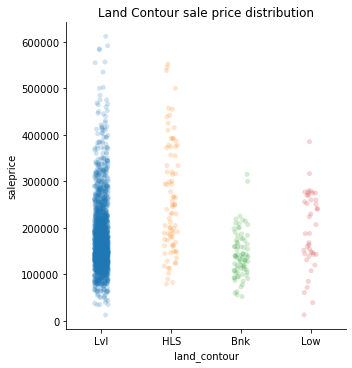

In [51]:
# plot
sns.catplot(x = 'land_contour', y= 'saleprice', data=train, alpha = 0.2)\
    .set(title = 'Land Contour sale price distribution');

In [52]:
train.groupby('land_contour').mean().saleprice

land_contour
Bnk    142651.924051
HLS    262595.678571
Low    194913.756098
Lvl    178998.564840
Name: saleprice, dtype: float64

**Observation** HLS has a mass higher in saleprice, change variable to `is_land_contour_hls`

In [53]:
# turn into is_land_countour_hls
train.land_contour = train.land_contour.map(lambda x: x == 'HLS').astype(int)
test.land_contour = test.land_contour.map(lambda x: x == 'HLS').astype(int)

train.rename(columns = {'land_contour': 'is_land_countour_hls'}, inplace=True)
test.rename(columns = {'land_contour': 'is_land_countour_hls'}, inplace=True)

train.iloc[[],:10]

,lot_frontage,lot_area,has_alley,is_lot_shape_regluar,is_land_countour_hls,utilities,lot_config,land_slope,neighborhood,condition_1
pid,,,,,,,,,,


#### review `utilities`

In [54]:
train.utilities.value_counts(normalize=True)

AllPub    0.999023
NoSeWa    0.000489
NoSewr    0.000489
Name: utilities, dtype: float64

**Observation**
only .3% of data set is not AllPub, drop column

In [55]:
train.drop('utilities', axis=1, inplace=True)
test.drop('utilities', axis=1, inplace=True)

train.iloc[[],:10]

,lot_frontage,lot_area,has_alley,is_lot_shape_regluar,is_land_countour_hls,lot_config,land_slope,neighborhood,condition_1,condition_2
pid,,,,,,,,,,


#### review `lot_config`

In [56]:
train.lot_config.value_counts(normalize=True)

Inside     0.733757
Corner     0.169516
CulDSac    0.063019
FR2        0.029311
FR3        0.004397
Name: lot_config, dtype: float64

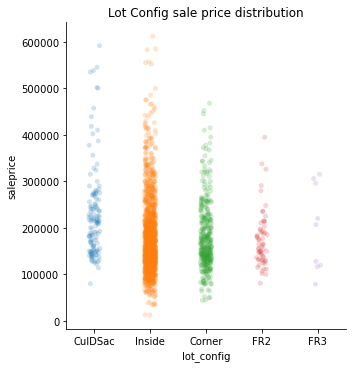

In [57]:
# plot
sns.catplot(x='lot_config', y='saleprice', data=train, alpha = 0.2)\
    .set(title = 'Lot Config sale price distribution');

**Observation**
  *  Breakout `Inside` and `Corner` separately.

In [58]:
# dummy
train = train.join(pd.get_dummies(train.lot_config, prefix = 'lot_config').loc[:,['lot_config_Inside','lot_config_Corner']])
test = test.join(pd.get_dummies(test.lot_config, prefix = 'lot_config').loc[:,['lot_config_Inside','lot_config_Corner']])

train.iloc[[],-5:]

,ms_subclass_group_2,ms_zoning_RL,ms_zoning_FV,lot_config_Inside,lot_config_Corner
pid,,,,,


In [59]:
# drop lot config
train.drop('lot_config', axis=1, inplace=True)
test.drop('lot_config', axis=1, inplace=True)

train.iloc[[],:10]

,lot_frontage,lot_area,has_alley,is_lot_shape_regluar,is_land_countour_hls,land_slope,neighborhood,condition_1,condition_2,bldg_type
pid,,,,,,,,,,


###  Cols [5,15] --> [5,7] after cleaning

In [60]:
train.columns[5:15]

Index(['land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod_add'],
      dtype='object')

In [61]:
train.dtypes[5:15]

land_slope        object
neighborhood      object
condition_1       object
condition_2       object
bldg_type         object
house_style       object
overall_qual       int64
overall_cond       int64
year_built         int64
year_remod_add     int64
dtype: object

In [62]:
# check for nulls
train.isnull().sum()[5:15]

# no nulls!

land_slope        0
neighborhood      0
condition_1       0
condition_2       0
bldg_type         0
house_style       0
overall_qual      0
overall_cond      0
year_built        0
year_remod_add    0
dtype: int64

In [63]:
test.isnull().sum()[5:15]

land_slope        0
neighborhood      0
condition_1       0
condition_2       0
bldg_type         0
house_style       0
overall_qual      0
overall_cond      0
year_built        0
year_remod_add    0
dtype: int64

#### review `land_slope`

In [64]:
train.land_slope.value_counts(normalize=True)

Gtl    0.953591
Mod    0.042501
Sev    0.003908
Name: land_slope, dtype: float64

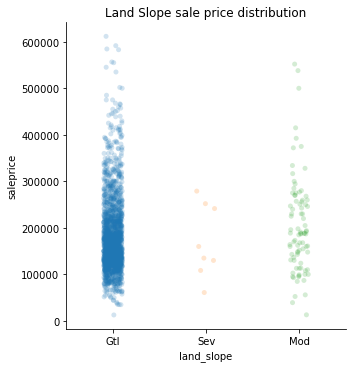

In [65]:
# plot
sns.catplot(x = 'land_slope', y='saleprice', data = train, alpha = 0.2)\
    .set(title = 'Land Slope sale price distribution');

In [66]:
train.groupby('land_slope').mean().saleprice

land_slope
Gtl    180368.906250
Mod    204210.034483
Sev    170872.500000
Name: saleprice, dtype: float64

**Observation** Sev has a mass higher in saleprice, change variable to `is_land_slope_mod`

In [67]:
# change to is_land_slope_mod

train.land_slope = train.land_slope.map(lambda x: x == 'Mod').astype(int)
test.land_slope = test.land_slope.map(lambda x: x == 'Mod').astype(int)

train.rename(columns = {'land_slope': 'is_land_slope_mod'}, inplace = True)
test.rename(columns = {'land_slope': 'is_land_slope_mod'}, inplace = True)

train.iloc[[],5:15]

,is_land_slope_mod,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod_add
pid,,,,,,,,,,


#### review `neighborhood`

In [68]:
# import values from data dictionary
neighborhood_from_dict = ['Blmngtn','Blueste','BrDale','BrkSide','ClearCr','CollgCr','Crawfor','Edwards',\
                          'Gilbert','Greens','GrnHill','IDOTRR','Landmrk','MeadowV','Mitchel','Names','NoRidge',\
                          'NPkVill','NridgHt','NWAmes','OldTown','SWISU','Sawyer','SawyerW','Somerst','StoneBr',\
                          'Timber','Veenker']

# confrim all values are in neightborhood dict
train[~train.neighborhood.isin(neighborhood_from_dict)].neighborhood.unique()

array(['NAmes'], dtype=object)

In [69]:
# rename 'NAmes' to be 'Names' to match data dictionary
train.neighborhood = train.neighborhood.map(lambda x: 'Names' if x == 'NAmes' else x)
test.neighborhood = test.neighborhood.map(lambda x: 'Names' if x == 'NAmes' else x)

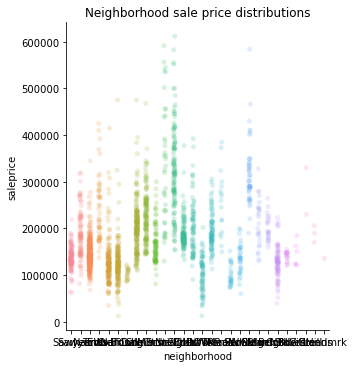

In [70]:
# plot
sns.catplot(x = 'neighborhood', y='saleprice', data = train, alpha = 0.2)\
    .set(title = 'Neighborhood sale price distributions');

**Observation**: Because of the wide range of values, separate into 4 bands:
  *  1 std deviation away negative
  *  \[1,0) std deviations away
  *  \[0,1) std deviations away
  *  1 std deviation away positive

In [71]:
n_train = pd.DataFrame(train.neighborhood.map(train.groupby('neighborhood').mean().\
                                              saleprice.map(lambda x: 0 if x < saleprice_mean - saleprice_std\
                                                          else 1 if x < saleprice_mean\
                                                          else 2 if x <= saleprice_mean + saleprice_std
                                                          else 3 if x > saleprice_mean + saleprice_std
                                                          else np.nan)))
n_test = pd.DataFrame(test.neighborhood.map(train.groupby('neighborhood').mean()\
                                            .saleprice.map(lambda x: 0 if x < saleprice_mean - saleprice_std\
                                                                  else 1 if x < saleprice_mean\
                                                                  else 2 if x <= saleprice_mean + saleprice_std
                                                                  else 3 if x > saleprice_mean + saleprice_std
                                                                  else np.nan)))
        






n_train.rename(columns = {'neighborhood': 'n_id'}, inplace=True)
n_test.rename(columns = {'neighborhood': 'n_id'}, inplace=True)

n_train= n_train.join(train[['neighborhood', 'saleprice']])

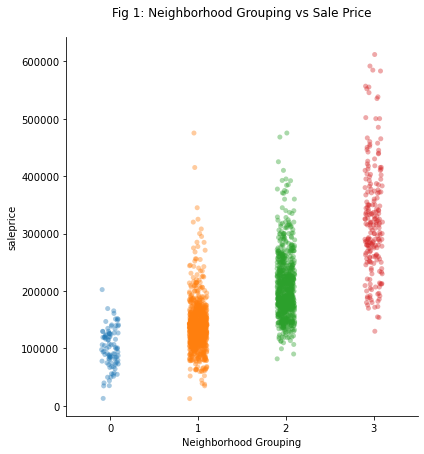

In [72]:
sns.catplot(x = 'n_id', y='saleprice', data = n_train, alpha = 0.4,
           height = 6)\
        .set(title='Fig 1: Neighborhood Grouping vs Sale Price\n')\
        .set(xlabel='Neighborhood Grouping');

**Observation**
  *  Split appears to be working as intended, add to train dataframe

In [73]:
train.shape

(2047, 80)

In [74]:
train = pd.merge(train,
             n_train[['n_id']],
             left_index = True,
             right_index = True)

In [75]:
# confirm merge only added one column
train.shape

(2047, 81)

In [76]:
# repeate process for test
test.shape

(878, 79)

In [77]:
test = pd.merge(test,
             n_test[['n_id']],
             left_index = True,
             right_index = True)

In [78]:
test.shape

(878, 80)

In [79]:
# rename n_id
train.rename(columns = {'n_id': 'neighborhood_group'}, inplace=True)
test.rename(columns = {'n_id': 'neighborhood_group'}, inplace=True)


train.head().iloc[:,-5:]

,ms_zoning_RL,ms_zoning_FV,lot_config_Inside,lot_config_Corner,neighborhood_group
pid,,,,,
533352170,1,0,0,0,1
531379050,1,0,0,0,2
535304180,1,0,1,0,1
916386060,1,0,1,0,2
906425045,1,0,1,0,2


In [80]:
test.iloc[[],-5:]

,ms_zoning_RL,ms_zoning_FV,lot_config_Inside,lot_config_Corner,neighborhood_group
pid,,,,,


In [81]:
# now we can dummy by neighborhood_group
train = train.join(pd.get_dummies(train.neighborhood_group, prefix = 'neighborhood_group')\
                   .loc[:,['neighborhood_group_1','neighborhood_group_2','neighborhood_group_3']])
test = test.join(pd.get_dummies(test.neighborhood_group, prefix = 'neighborhood_group')\
                   .loc[:,['neighborhood_group_1','neighborhood_group_2','neighborhood_group_3']])


train.iloc[[],-5:]

,lot_config_Corner,neighborhood_group,neighborhood_group_1,neighborhood_group_2,neighborhood_group_3
pid,,,,,


In [82]:
# drop neighborhood, neighborhood_group
train.drop(['neighborhood','neighborhood_group'], axis=1, inplace = True)
test.drop(['neighborhood','neighborhood_group'], axis=1, inplace = True)

train.iloc[[],5:15]


,is_land_slope_mod,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod_add,roof_style
pid,,,,,,,,,,


#### review `condition_1` & `condition_2` together

In [83]:
train.condition_1.value_counts()

Norm      1765
Feedr      108
Artery      70
RRAn        36
PosN        27
RRAe        21
PosA        11
RRNn         6
RRNe         3
Name: condition_1, dtype: int64

In [84]:
train.condition_2.value_counts()

Norm      2021
Feedr       11
Artery       5
PosA         3
PosN         3
RRNn         2
RRAe         1
RRAn         1
Name: condition_2, dtype: int64

In [85]:
# review these merged together
pd.DataFrame(train.condition_1 + train.condition_2)[0].value_counts(normalize=True)

NormNorm        0.862237
FeedrNorm       0.049340
ArteryNorm      0.032731
RRAnNorm        0.013190
PosNNorm        0.011724
RRAeNorm        0.010259
PosANorm        0.004397
RRAnFeedr       0.003908
RRNnNorm        0.001954
RRNeNorm        0.001466
PosNPosN        0.001466
FeedrRRNn       0.000977
ArteryArtery    0.000977
FeedrFeedr      0.000977
PosAPosA        0.000977
FeedrRRAe       0.000489
RRNnFeedr       0.000489
ArteryPosA      0.000489
RRAnArtery      0.000489
RRNnArtery      0.000489
FeedrArtery     0.000489
FeedrRRAn       0.000489
Name: 0, dtype: float64

In [86]:
# get absolute membership

conditions = pd.DataFrame(train.condition_1 + ';' + train.condition_2,
                          columns = ['conditions'])

conditions.conditions.str.get_dummies(';').mean().sort_values()

RRNe      0.001466
RRNn      0.003908
PosA      0.005862
RRAe      0.010747
PosN      0.013190
RRAn      0.018075
Artery    0.035662
Feedr     0.057157
Norm      0.987298
dtype: float64

In [87]:
# consolidate condition_1 and condition_2 into is_condition_normal 
train = train.join(train.apply(lambda row: row.condition_1 == 'Norm' or row.condition_2 == 'Norm',
                               axis = 1)\
                   .rename('is_condition_normal'))

test = test.join(test.apply(lambda row: row.condition_1 == 'Norm' or row.condition_2 == 'Norm',
                               axis = 1)\
                   .rename('is_condition_normal'))

train.iloc[[],-5:]

,lot_config_Corner,neighborhood_group_1,neighborhood_group_2,neighborhood_group_3,is_condition_normal
pid,,,,,


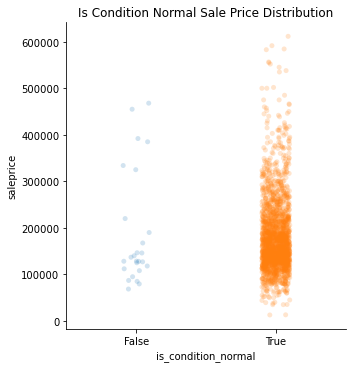

In [88]:
# plot it
sns.catplot(x = 'is_condition_normal', y='saleprice', data=train, alpha = 0.2)\
    .set(title = 'Is Condition Normal Sale Price Distribution');

**Observation** There just isn't enough variation between bands. Drop `is_condition_normal`

In [89]:
# drop condition columns, is_condition_normal
train.drop(['condition_1', 'condition_2','is_condition_normal'], axis = 1, inplace = True)
test.drop(['condition_1', 'condition_2','is_condition_normal'], axis = 1, inplace = True)

train.iloc[[],5:15]

,is_land_slope_mod,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod_add,roof_style,roof_matl,exterior_1st
pid,,,,,,,,,,


### review `bldg_type`

In [90]:
train.bldg_type.value_counts(normalize=True)

1Fam      0.828530
TwnhsE    0.078652
Duplex    0.036639
Twnhs     0.033708
2fmCon    0.022472
Name: bldg_type, dtype: float64

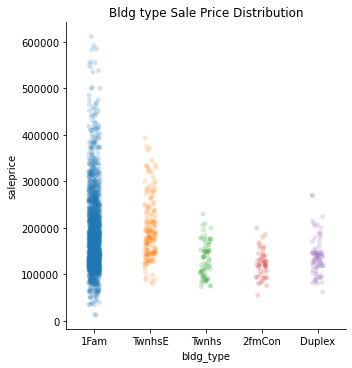

In [91]:
sns.catplot(x = 'bldg_type', y = 'saleprice', data = train, alpha = 0.2)\
    .set(title = 'Bldg type Sale Price Distribution');

In [92]:
train.groupby('bldg_type').mean().saleprice

bldg_type
1Fam      185134.237028
2fmCon    123179.891304
Duplex    139296.333333
Twnhs     133100.000000
TwnhsE    198312.372671
Name: saleprice, dtype: float64

**Observation** make two dummies, one for 1Fam and one for TwnhsE

In [93]:
train = train.join(pd.get_dummies(train.bldg_type, prefix = 'bldg_type').loc[:,['bldg_type_1Fam','bldg_type_TwnhsE']])
test = test.join(pd.get_dummies(test.bldg_type, prefix = 'bldg_type').loc[:,['bldg_type_1Fam','bldg_type_TwnhsE']])

train.iloc[[],-5:]

,neighborhood_group_1,neighborhood_group_2,neighborhood_group_3,bldg_type_1Fam,bldg_type_TwnhsE
pid,,,,,


In [94]:
# drop 'bldg_type'
train.drop('bldg_type', axis = 1, inplace = True)
test.drop('bldg_type', axis = 1, inplace = True)

train.iloc[[],5:15]

,is_land_slope_mod,house_style,overall_qual,overall_cond,year_built,year_remod_add,roof_style,roof_matl,exterior_1st,exterior_2nd
pid,,,,,,,,,,


#### review `house_style`

In [95]:
train.house_style.value_counts(normalize=True)

1Story    0.516365
2Story    0.291646
1.5Fin    0.106009
SLvl      0.045921
SFoyer    0.024426
2.5Unf    0.006839
1.5Unf    0.005862
2.5Fin    0.002931
Name: house_style, dtype: float64

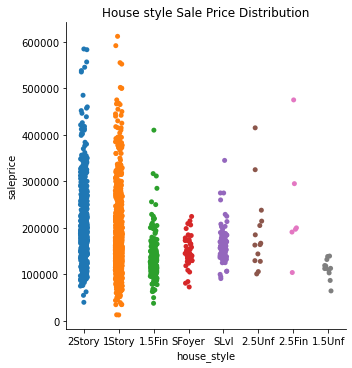

In [96]:
# plot
sns.catplot(x = 'house_style', y = 'saleprice', data = train)\
    .set(title = 'House style Sale Price Distribution');

**Observation** Separate out 2Story and 1Story

In [97]:
# create 2 dummies
train = train.join(pd.get_dummies(train.house_style, prefix = 'house_style').loc[:,['house_style_2Story','house_style_1Story']])
test = test.join(pd.get_dummies(test.house_style, prefix = 'house_style').loc[:,['house_style_2Story','house_style_1Story']])

train.iloc[[],-5:]

,neighborhood_group_3,bldg_type_1Fam,bldg_type_TwnhsE,house_style_2Story,house_style_1Story
pid,,,,,


In [98]:
# drop house_style
train.drop('house_style', axis = 1, inplace = True)
test.drop('house_style', axis = 1, inplace = True)

train.iloc[[],5:15]

,is_land_slope_mod,overall_qual,overall_cond,year_built,year_remod_add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type
pid,,,,,,,,,,


#### review `overall_qual`

In [99]:
train.overall_qual.describe()

count    2047.000000
mean        6.109428
std         1.424799
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: overall_qual, dtype: float64

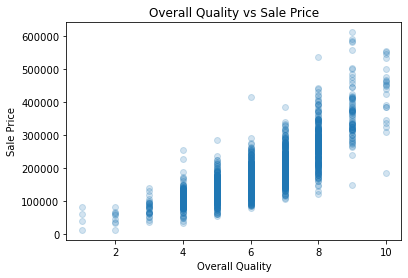

In [100]:
# plot
plt.scatter(x = train.overall_qual, y= train.saleprice, alpha = 0.2)
plt.title('Overall Quality vs Sale Price')
plt.xlabel('Overall Quality')
plt.ylabel('Sale Price');

**Observation** Maintain as ordinal

#### review `overall_cond`

In [101]:
train.overall_cond.describe()

count    2047.000000
mean        5.561309
std         1.104522
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: overall_cond, dtype: float64

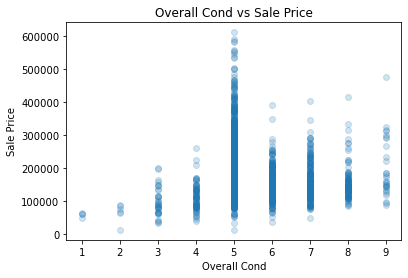

In [102]:
# plot
plt.scatter(x = train.overall_cond, y= train.saleprice, alpha = 0.2)
plt.title('Overall Cond vs Sale Price')
plt.xlabel('Overall Cond')
plt.ylabel('Sale Price');

In [103]:
train.groupby('overall_cond').mean().saleprice

overall_cond
1     59625.000000
2     65364.833333
3     99786.000000
4    114034.571429
5    207014.918525
6    148952.665761
7    154549.861940
8    155913.366337
9    198177.586207
Name: saleprice, dtype: float64

In [104]:
train.groupby('overall_cond').std().saleprice

overall_cond
1     6625.393070
2    27373.892309
3    42905.475402
4    41244.296590
5    86439.592939
6    42074.269804
7    50674.187464
8    53765.853890
9    90026.013687
Name: saleprice, dtype: float64

In [105]:
train.overall_cond.value_counts(normalize=True)

5    0.569614
6    0.179775
7    0.130923
8    0.049340
4    0.034196
3    0.017098
9    0.014167
2    0.002931
1    0.001954
Name: overall_cond, dtype: float64

**Observation** `overall_cond` has a huge amount of 5's which create the largest mean saleprice as well as the largest std. For this reason, the ordinal is not indicative of a good positive correlation and should be dropped.

In [106]:
# drop overall_cond
train.drop('overall_cond', axis=1, inplace=True)
test.drop('overall_cond', axis=1, inplace=True)

train.iloc[[],5:15]

,is_land_slope_mod,overall_qual,year_built,year_remod_add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area
pid,,,,,,,,,,


#### review `year_built`

In [107]:
train.year_built.describe()

count    2047.000000
mean     1971.703957
std        30.194082
min      1872.000000
25%      1953.000000
50%      1974.000000
75%      2001.000000
max      2010.000000
Name: year_built, dtype: float64

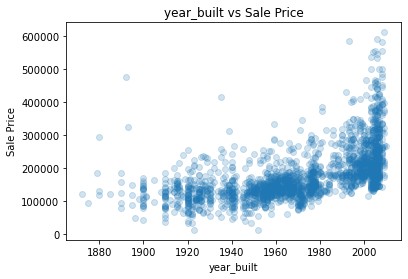

In [108]:
# plot
plt.scatter(x=train.year_built, y=train.saleprice, alpha = 0.2)
plt.title('year_built vs Sale Price')
plt.xlabel('year_built')
plt.ylabel('Sale Price');

In [109]:
# convert this to home_age
train['home_age'] = train.year_built.map(lambda x: 2010 - x)
test['home_age'] = test.year_built.map(lambda x: 2010 - x)

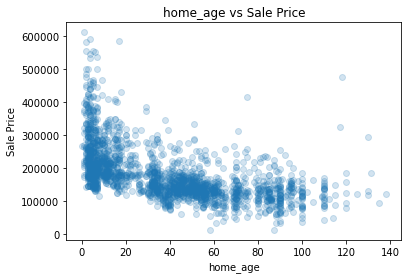

In [110]:
# plot
plt.scatter(x = train.home_age, y= train.saleprice, alpha = 0.2)
plt.title('home_age vs Sale Price')
plt.xlabel('home_age')
plt.ylabel('Sale Price');

**Observation** Negative correlation between `home_age` and `saleprice` 

#### review `year_remod`

In [111]:
train.year_remod_add.describe()

count    2047.000000
mean     1984.148021
std        21.034931
min      1950.000000
25%      1964.000000
50%      1993.000000
75%      2004.000000
max      2010.000000
Name: year_remod_add, dtype: float64

In [112]:
# let's assume that no remodels were made the year the home was built. Create a bool for has_remodel
home_has_remodel = train.year_remod_add == train.year_built
test_home_has_remodel = test.year_remod_add == test.year_built

train['home_has_remodel'] = home_has_remodel.astype(int)
test['home_has_remodel'] = test_home_has_remodel.astype(int)



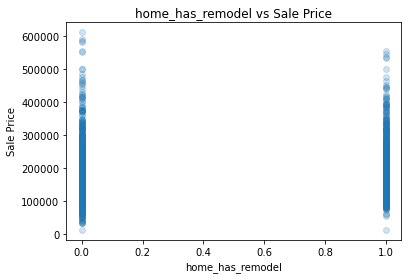

In [113]:
# plot
plt.scatter(x=train.home_has_remodel, y=train.saleprice, alpha=0.2)
plt.title('home_has_remodel vs Sale Price')
plt.xlabel('home_has_remodel')
plt.ylabel('Sale Price');

**Observation** No clear relationship. Drop it.

In [114]:
#drop year_built and year_remod_add
train.drop(['year_built','year_remod_add'], axis = 1, inplace = True)
test.drop(['year_built','year_remod_add'], axis = 1, inplace = True)

train.iloc[[],5:15]

,is_land_slope_mod,overall_qual,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond
pid,,,,,,,,,,


###  Cols [7:17] --> [7,10] after cleaning

In [115]:
train.columns[7:17]

Index(['roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd',
       'mas_vnr_type', 'mas_vnr_area', 'exter_qual', 'exter_cond',
       'foundation', 'bsmt_qual'],
      dtype='object')

In [116]:
train.dtypes[7:17]

roof_style       object
roof_matl        object
exterior_1st     object
exterior_2nd     object
mas_vnr_type     object
mas_vnr_area    float64
exter_qual       object
exter_cond       object
foundation       object
bsmt_qual        object
dtype: object

In [117]:
# check for nulls
train.isnull().sum()[7:17]

roof_style       0
roof_matl        0
exterior_1st     0
exterior_2nd     0
mas_vnr_type    22
mas_vnr_area    22
exter_qual       0
exter_cond       0
foundation       0
bsmt_qual       55
dtype: int64

In [118]:
test.isnull().sum()[7:17]

roof_style       0
roof_matl        0
exterior_1st     0
exterior_2nd     0
mas_vnr_type     1
mas_vnr_area     1
exter_qual       0
exter_cond       0
foundation       0
bsmt_qual       25
dtype: int64

#### Address `mas_vnr_type` nulls

In [119]:
train.mas_vnr_type.map(lambda x: 0 if pd.isnull(x) else x).value_counts(normalize = True)

None       0.594529
BrkFace    0.307767
Stone      0.081094
0          0.010747
BrkCmn     0.005862
Name: mas_vnr_type, dtype: float64

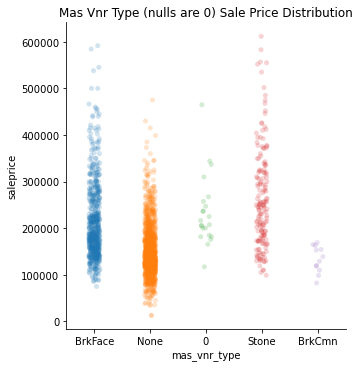

In [120]:
# plot it
sns.catplot(x = 'mas_vnr_type', y='saleprice',
            data=pd.DataFrame(train.mas_vnr_type.map(lambda x: 0 if pd.isnull(x) else x)).join(train.saleprice),
            alpha=0.2)\
    .set(title = 'Mas Vnr Type (nulls are 0) Sale Price Distribution');

**Observation** rather than nulls impute, make a dummy for Stone and BrkFace

In [121]:
train = train.join(pd.get_dummies(train.mas_vnr_type, prefix = 'mas_vnr_type')\
                   .loc[:,['mas_vnr_type_Stone','mas_vnr_type_BrkFace']])
test = test.join(pd.get_dummies(test.mas_vnr_type, prefix = 'mas_vnr_type')\
                   .loc[:,['mas_vnr_type_Stone','mas_vnr_type_BrkFace']])


train.iloc[[],-5:]

,house_style_1Story,home_age,home_has_remodel,mas_vnr_type_Stone,mas_vnr_type_BrkFace
pid,,,,,


In [122]:
# drop mas_vnr_type
train.drop('mas_vnr_type', axis=1, inplace=True)
test.drop('mas_vnr_type', axis=1, inplace=True)

train.iloc[[],7:17]

,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond
pid,,,,,,,,,,


#### review `mas_vnr_area`

In [123]:
train.mas_vnr_area.describe()

count    2025.000000
mean       99.093333
std       174.149618
min         0.000000
25%         0.000000
50%         0.000000
75%       160.000000
max      1600.000000
Name: mas_vnr_area, dtype: float64

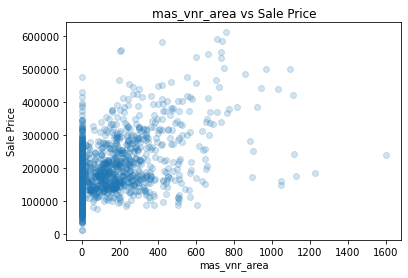

In [124]:
# plot
plt.scatter(train.mas_vnr_area, train.saleprice, alpha = 0.2)
plt.title('mas_vnr_area vs Sale Price')
plt.xlabel('mas_vnr_area')
plt.ylabel('Sale Price');

In [125]:
# impute nulls with median
mas_vnr_area_median = train.mas_vnr_area.describe()['50%']

train.mas_vnr_area = train.mas_vnr_area.map(lambda x: mas_vnr_area_median if pd.isnull(x) else x)
test.mas_vnr_area = test.mas_vnr_area.map(lambda x: mas_vnr_area_median if pd.isnull(x) else x)


train.mas_vnr_area.describe()

count    2047.000000
mean       98.028334
std       173.512052
min         0.000000
25%         0.000000
50%         0.000000
75%       158.000000
max      1600.000000
Name: mas_vnr_area, dtype: float64

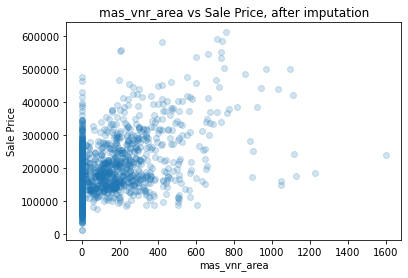

In [126]:
# plot
plt.scatter(train.mas_vnr_area, train.saleprice, alpha = 0.2)
plt.title('mas_vnr_area vs Sale Price, after imputation')
plt.xlabel('mas_vnr_area')
plt.ylabel('Sale Price');

**Observation**: looks positively correlated. Keep it

#### review `bsmt_qual`

In [127]:
train.bsmt_qual.map(lambda x: 0 if pd.isnull(x) else x).value_counts()

TA    887
Gd    861
Ex    183
Fa     60
0      55
Po      1
Name: bsmt_qual, dtype: int64

In [128]:
# there are a lot of basement things, let's look at all of them and create some helpers
basements = train[['bsmt_qual','bsmt_cond', 'bsmt_exposure','bsmtfin_type_1','bsmtfin_sf_1','bsmtfin_type_2','bsmtfin_sf_2',\
                  'bsmt_unf_sf','total_bsmt_sf','bsmt_full_bath','bsmt_half_bath']]

In [129]:
basements.isnull().sum()

bsmt_qual         55
bsmt_cond         55
bsmt_exposure     58
bsmtfin_type_1    55
bsmtfin_sf_1       1
bsmtfin_type_2    56
bsmtfin_sf_2       1
bsmt_unf_sf        1
total_bsmt_sf      1
bsmt_full_bath     2
bsmt_half_bath     2
dtype: int64

**Observations**
  *  `bsmt_exposure` includes unfinished basements
  *  `bsmt_qual` has 55 nulls which are uniform across all basement categories (either as null or 0). This can be expanded out
      to a "has_basement" indicator

In [130]:
# impute bsmt_qual with 'NA'
train.bsmt_qual = train.bsmt_qual.map(lambda x: 'NA' if pd.isnull(x) else x)
test.bsmt_qual = test.bsmt_qual.map(lambda x: 'NA' if pd.isnull(x) else x)

In [131]:
# create "has_basement"
train['has_basement'] = train.bsmt_qual != 'NA'
test['has_basement'] = test.bsmt_qual != 'NA'

train.has_basement = train.has_basement.map(lambda x: x).astype(int)
test.has_basement = test.has_basement.map(lambda x: x).astype(int)

train.has_basement.value_counts()

1    1992
0      55
Name: has_basement, dtype: int64

#### review `roof_style`

In [132]:
train.roof_style.value_counts(normalize = True)

Gable      0.789936
Hip        0.193454
Flat       0.005862
Gambrel    0.005862
Mansard    0.003420
Shed       0.001466
Name: roof_style, dtype: float64

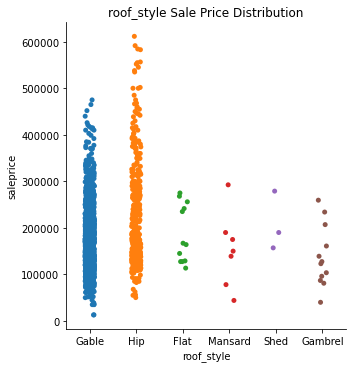

In [133]:
# plot
sns.catplot(x = 'roof_style', y='saleprice', data = train)\
    .set(title = 'roof_style Sale Price Distribution');

In [134]:
# create two dummies
train = train.join(pd.get_dummies(train.roof_style, prefix = 'roof_style').loc[:,['roof_style_Gable','roof_style_Hip']])
test = test.join(pd.get_dummies(test.roof_style, prefix = 'roof_style').loc[:,['roof_style_Gable','roof_style_Hip']])

In [135]:
# drop roof_style
train.drop('roof_style', axis = 1, inplace=True)
test.drop('roof_style', axis = 1, inplace=True)

train.iloc[[],7:17]

,roof_matl,exterior_1st,exterior_2nd,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure
pid,,,,,,,,,,


#### review `roof_matl`

In [136]:
train.roof_matl.value_counts(normalize=True)

CompShg    0.988276
Tar&Grv    0.006839
WdShngl    0.002443
WdShake    0.001954
Membran    0.000489
Name: roof_matl, dtype: float64

In [137]:
# drop it
train.drop('roof_matl', axis = 1, inplace=True)
test.drop('roof_matl', axis = 1, inplace=True)


train.iloc[[],9:19]

,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2
pid,,,,,,,,,,


#### review `exterior_1st` & `exterior_2nd`

In [138]:
# import exterior 1st values from data dictionary
exterior_1st_from_dict = ['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CemntBd','HdBoard','ImStucc',\
                          'MetalSd','Other','Plywood','PreCast','Stone','Stucco','VinylSd','Wd Sdng','WdShing']

# check to see if all exterior 1st values are in dictionary
train[~train.exterior_1st.isin(exterior_1st_from_dict)]

,lot_frontage,lot_area,has_alley,is_lot_shape_regluar,is_land_countour_hls,is_land_slope_mod,overall_qual,exterior_1st,exterior_2nd,mas_vnr_area,...,bldg_type_TwnhsE,house_style_2Story,house_style_1Story,home_age,home_has_remodel,mas_vnr_type_Stone,mas_vnr_type_BrkFace,has_basement,roof_style_Gable,roof_style_Hip
pid,,,,,,,,,,,,,,,,,,,,,


In [139]:
test[~test.exterior_1st.isin(exterior_1st_from_dict)]

,lot_frontage,lot_area,has_alley,is_lot_shape_regluar,is_land_countour_hls,is_land_slope_mod,overall_qual,exterior_1st,exterior_2nd,mas_vnr_area,...,bldg_type_TwnhsE,house_style_2Story,house_style_1Story,home_age,home_has_remodel,mas_vnr_type_Stone,mas_vnr_type_BrkFace,has_basement,roof_style_Gable,roof_style_Hip
pid,,,,,,,,,,,,,,,,,,,,,


In [140]:
# repeat for exterior_2nd
train[~train.exterior_2nd.isin(exterior_1st_from_dict)].exterior_2nd.unique()

array(['CmentBd', 'Wd Shng', 'Brk Cmn'], dtype=object)

In [141]:
test[~test.exterior_2nd.isin(exterior_1st_from_dict)].exterior_2nd.unique()

array(['CmentBd', 'Wd Shng', 'Brk Cmn'], dtype=object)

In [142]:
# replace vals
train.exterior_2nd = ['CemntBd' if val == 'CmentBd' else 'WdShing' if val == 'Wd Shng' else 'BrkComm' if val == 'Brk Cmn'\
else val for val in train.exterior_2nd]

test.exterior_2nd = ['CemntBd' if val == 'CmentBd' else 'WdShing' if val == 'Wd Shng' else 'BrkComm' if val == 'Brk Cmn'\
else val for val in test.exterior_2nd]

train[~train.exterior_2nd.isin(exterior_1st_from_dict)].exterior_2nd.unique()

array([], dtype=object)

In [143]:
test[~test.exterior_2nd.isin(exterior_1st_from_dict)].exterior_2nd.unique()

array([], dtype=object)

In [144]:
# get absolute membership

exteriors = pd.DataFrame(train.exterior_1st + ';' + train.exterior_2nd, columns = ['exteriors'])
test_exteriors = pd.DataFrame(test.exterior_1st + ';' + test.exterior_2nd, columns = ['exteriors'])


exteriors.exteriors.str.get_dummies(';').mean().sort_values()

AsphShn    0.001466
CBlock     0.001466
Stone      0.003420
ImStucc    0.005374
BrkComm    0.008305
AsbShng    0.017587
Stucco     0.017587
BrkFace    0.032242
WdShing    0.036150
CemntBd    0.044455
Plywood    0.103566
Wd Sdng    0.146556
HdBoard    0.153884
MetalSd    0.163166
VinylSd    0.358085
dtype: float64

In [145]:
# make dummies for vinyl, metal, hd, wd, ply
exteriors = exteriors.exteriors.str.get_dummies(';').loc[:,['VinylSd','MetalSd','HdBoard','Wd Sdng','Plywood']]
test_exteriors = test_exteriors.exteriors.str.get_dummies(';').loc[:,['VinylSd','MetalSd','HdBoard','Wd Sdng','Plywood']]

exteriors.rename(columns = {col: 'exterior_has_'+col.replace(' ','_') for col in exteriors.columns}, inplace = True)
test_exteriors.rename(columns = {col: 'exterior_has_'+col.replace(' ','_') for col in test_exteriors.columns}, inplace = True)

train = train.join(exteriors)
test = test.join(test_exteriors)

train.iloc[[],-7:]

,roof_style_Gable,roof_style_Hip,exterior_has_VinylSd,exterior_has_MetalSd,exterior_has_HdBoard,exterior_has_Wd_Sdng,exterior_has_Plywood
pid,,,,,,,


In [146]:
# drop exterior cols
train.drop(['exterior_1st','exterior_2nd'], axis = 1, inplace = True)
test.drop(['exterior_1st','exterior_2nd'], axis = 1, inplace = True)

train.iloc[[],7:17]

,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2
pid,,,,,,,,,,


#### review `exter_qual`

In [147]:
train.exter_qual.value_counts(normalize=True)

TA    0.608207
Gd    0.340010
Ex    0.039082
Fa    0.012702
Name: exter_qual, dtype: float64

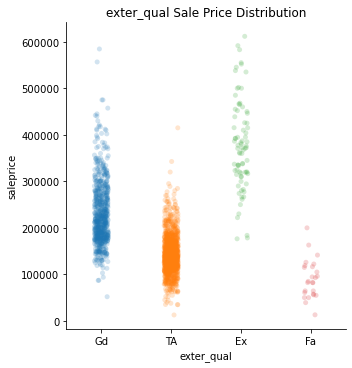

In [148]:
# plot it
sns.catplot(x = 'exter_qual', y='saleprice', data = train, alpha=0.2)\
    .set(title = 'exter_qual Sale Price Distribution');

In [149]:
# dummy EX_GD together
train.exter_qual = train.exter_qual.map(lambda x: x == 'Gd' or x == 'Ex').astype(int)
test.exter_qual = test.exter_qual.map(lambda x: x == 'Gd' or x == 'Ex').astype(int)

train.rename(columns = {'exter_qual':'exter_qual_Ex_Gd'}, inplace=True)
test.rename(columns = {'exter_qual':'exter_qual_Ex_Gd'}, inplace=True)

train.iloc[[],7:17]

,mas_vnr_area,exter_qual_Ex_Gd,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2
pid,,,,,,,,,,


#### review `exter_cond`

In [150]:
train.exter_cond.value_counts(normalize = True)

TA    0.866634
Gd    0.105032
Fa    0.023937
Ex    0.003420
Po    0.000977
Name: exter_cond, dtype: float64

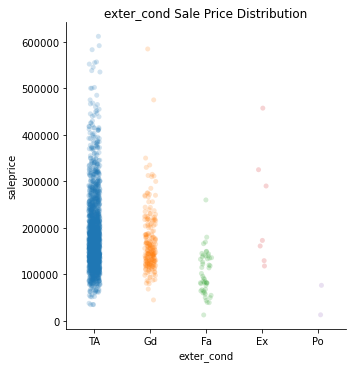

In [151]:
# plot it
sns.catplot(x = 'exter_cond', y='saleprice', data = train, alpha=0.2)\
    .set(title = 'exter_cond Sale Price Distribution');

**Observation** There is no clear separation between TA and the rest of the values. Drop this column

In [152]:
# drop exter_cond
train.drop('exter_cond', axis = 1, inplace=True)
test.drop('exter_cond', axis = 1, inplace=True)

train.iloc[[],7:17]

,mas_vnr_area,exter_qual_Ex_Gd,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2
pid,,,,,,,,,,


#### review `foundation`

In [153]:
train.foundation.value_counts(normalize=True)

PConc     0.451881
CBlock    0.420127
BrkTil    0.107963
Slab      0.016610
Stone     0.002443
Wood      0.000977
Name: foundation, dtype: float64

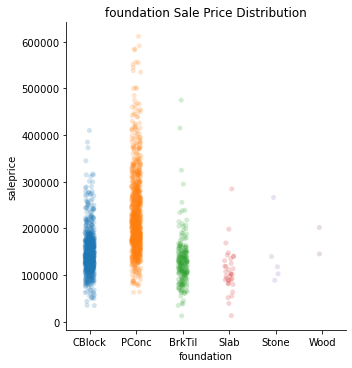

In [154]:
# plot it
sns.catplot(x = 'foundation', y='saleprice', data = train, alpha=0.2)\
    .set(title = 'foundation Sale Price Distribution');

In [155]:
# dummy Pconc and Cblock
train = train.join(pd.get_dummies(train.foundation, prefix = 'foundation')\
                   .loc[:,['foundation_PConc','foundation_CBlock']])
test = test.join(pd.get_dummies(test.foundation, prefix = 'foundation')\
                   .loc[:,['foundation_PConc','foundation_CBlock']])


train.iloc[[],-5:]

,exterior_has_HdBoard,exterior_has_Wd_Sdng,exterior_has_Plywood,foundation_PConc,foundation_CBlock
pid,,,,,


In [156]:
#drop foundation
train.drop('foundation', axis=1, inplace=True)
test.drop('foundation', axis=1, inplace=True)

train.iloc[[],7:17]

,mas_vnr_area,exter_qual_Ex_Gd,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf
pid,,,,,,,,,,


#### review `bsmt_qual`

In [157]:
train.bsmt_qual.value_counts(normalize=True)

TA    0.433317
Gd    0.420616
Ex    0.089399
Fa    0.029311
NA    0.026869
Po    0.000489
Name: bsmt_qual, dtype: float64

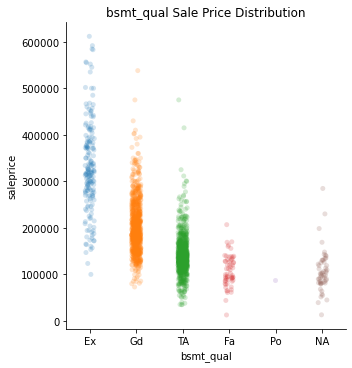

In [158]:
# plot it
sns.catplot(x = 'bsmt_qual', y='saleprice', data = train, alpha=0.2,
            order = ['Ex','Gd','TA','Fa','Po','NA'])\
    .set(title = 'bsmt_qual Sale Price Distribution');

In [159]:
# dummy EX_GD together
train.bsmt_qual = train.bsmt_qual.map(lambda x: x == 'Gd' or x == 'Ex').astype(int)
test.bsmt_qual = test.bsmt_qual.map(lambda x: x == 'Gd' or x == 'Ex').astype(int)

train.rename(columns = {'bsmt_qual':'bsmt_qual_Ex_Gd'}, inplace=True)
test.rename(columns = {'bsmt_qual':'bsmt_qual_Ex_Gd'}, inplace=True)

train.iloc[[],7:17]

,mas_vnr_area,exter_qual_Ex_Gd,bsmt_qual_Ex_Gd,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf
pid,,,,,,,,,,


### Cols [10:20] --> [10,15] after cleaning

In [160]:
train.columns[10:20]

Index(['bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc'],
      dtype='object')

In [161]:
train.dtypes[10:20]

bsmt_cond          object
bsmt_exposure      object
bsmtfin_type_1     object
bsmtfin_sf_1      float64
bsmtfin_type_2     object
bsmtfin_sf_2      float64
bsmt_unf_sf       float64
total_bsmt_sf     float64
heating            object
heating_qc         object
dtype: object

In [162]:
# check for nulls
train.isnull().sum()[10:20]

bsmt_cond         55
bsmt_exposure     58
bsmtfin_type_1    55
bsmtfin_sf_1       1
bsmtfin_type_2    56
bsmtfin_sf_2       1
bsmt_unf_sf        1
total_bsmt_sf      1
heating            0
heating_qc         0
dtype: int64

#### address `bsmt_cond` nulls

In [163]:
train[train.bsmt_cond.isnull()].has_basement.value_counts()

0    55
Name: has_basement, dtype: int64

In [164]:
# update to NA
train.bsmt_cond = train.bsmt_cond.map(lambda x: 'NA' if pd.isnull(x) else x)
test.bsmt_cond = test.bsmt_cond.map(lambda x: 'NA' if pd.isnull(x) else x)

#### review `bsmt_cond`

In [165]:
train.bsmt_cond.value_counts(normalize=True)

TA    0.893991
Gd    0.043478
Fa    0.031754
NA    0.026869
Po    0.002443
Ex    0.001466
Name: bsmt_cond, dtype: float64

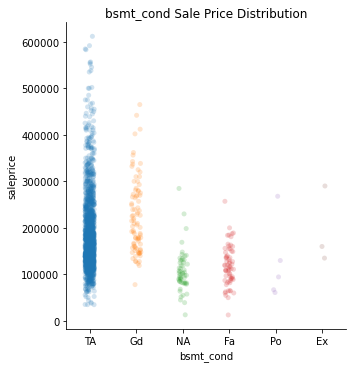

In [166]:
#plot
sns.catplot(x = 'bsmt_cond', y='saleprice', data = train, alpha=0.2)\
    .set(title = 'bsmt_cond Sale Price Distribution');

In [167]:
# dummy to TA or above
train.bsmt_cond = train.bsmt_cond.map(lambda x: x == 'TA' or x == 'Gd' or x=='Ex').astype(int)
test.bsmt_cond = test.bsmt_cond.map(lambda x: x == 'TA' or x == 'Gd' or x=='Ex').astype(int)

train.rename(columns = {'bsmt_cond': 'bsmt_cond_is_TA_Gd_Ex'}, inplace=True)
test.rename(columns = {'bsmt_cond': 'bsmt_cond_is_TA_Gd_Ex'}, inplace=True)

train.iloc[[],10:20]

,bsmt_cond_is_TA_Gd_Ex,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc
pid,,,,,,,,,,


#### address `bsmt_exposure` nulls

In [168]:
train[train.bsmt_exposure.isnull()].has_basement.value_counts()

0    55
1     3
Name: has_basement, dtype: int64

In [169]:
train.bsmt_exposure.map(lambda x: 0 if pd.isnull(x) else x).value_counts(normalize=True)

No    0.654128
Av    0.140694
Gd    0.097215
Mn    0.079629
0     0.028334
Name: bsmt_exposure, dtype: float64

In [170]:
train[train.bsmt_exposure.isnull()].has_basement.value_counts()

0    55
1     3
Name: has_basement, dtype: int64

In [171]:
test[test.bsmt_exposure.isnull()].has_basement.value_counts()

0    25
Name: has_basement, dtype: int64

In [172]:
# investigate 3 nulls with basement
train[(train.bsmt_exposure.isnull())&(train.has_basement==1)].iloc[:,13:23]

,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf
pid,,,,,,,,,,
528458090,0.0,Unf,0.0,725.0,725.0,GasA,Ex,Y,SBrkr,725
528445060,0.0,Unf,0.0,1595.0,1595.0,GasA,Ex,Y,SBrkr,1595
907194130,0.0,Unf,0.0,936.0,936.0,GasA,Ex,Y,SBrkr,936


In [173]:
# see most common exposure for unf basements
train[train.bsmtfin_type_1 == 'Unf'].bsmt_exposure.value_counts()

No    478
Av     62
Mn     41
Gd     19
Name: bsmt_exposure, dtype: int64

In [174]:
# impute 3 nulls with basement to 'No'
train.bsmt_exposure = train.apply(lambda row: 'No' if pd.isnull(row.bsmt_exposure) and row.bsmtfin_type_1 == 'Unf'\
                                  else row.bsmt_exposure,
                                  axis = 1)

In [175]:
# impute remaining nulls to 'NA'
train.bsmt_exposure = train.bsmt_exposure.map(lambda x: 'NA' if pd.isnull(x) else x)
test.bsmt_exposure = test.bsmt_exposure.map(lambda x: 'NA' if pd.isnull(x) else x)

In [176]:
train.bsmt_exposure.value_counts(normalize=True)

No    0.655594
Av    0.140694
Gd    0.097215
Mn    0.079629
NA    0.026869
Name: bsmt_exposure, dtype: float64

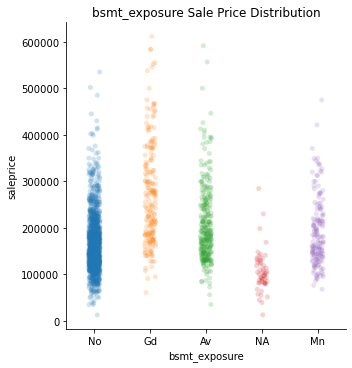

In [177]:
# plot it
sns.catplot(x = 'bsmt_exposure', y = 'saleprice', data = train, alpha = 0.2)\
    .set(title = 'bsmt_exposure Sale Price Distribution');

In [178]:
# dummy to has_exposure
train.bsmt_exposure = train.bsmt_exposure.map(lambda x: x == 'Gd' or x=='Mn' or x=='Av').astype(int)
test.bsmt_exposure = test.bsmt_exposure.map(lambda x: x == 'Gd' or x=='Mn' or x=='Av').astype(int)

train.rename(columns = {'bsmt_exposure': 'has_bsmt_exposure'}, inplace=True)
test.rename(columns = {'bsmt_exposure': 'has_bsmt_exposure'}, inplace=True)

#### review `bsmtfin_type_1`, `bsmtfin_sf_1`, `bsmtfin_type_2`, `bsmtfin_sf_2`

In [179]:
train.bsmtfin_type_1.unique()

array(['GLQ', 'Unf', 'ALQ', 'Rec', nan, 'BLQ', 'LwQ'], dtype=object)

In [180]:
# confirm nulls don't have basements
train[train.bsmtfin_type_1.isnull()].has_basement.value_counts()

0    55
Name: has_basement, dtype: int64

In [181]:
test[test.bsmtfin_type_1.isnull()].has_basement.value_counts()

0    25
Name: has_basement, dtype: int64

In [182]:
# impute to 'NA'
train.bsmtfin_type_1 = train.bsmtfin_type_1.map(lambda x: 'NA' if pd.isnull(x) else x)
test.bsmtfin_type_1 = test.bsmtfin_type_1.map(lambda x: 'NA' if pd.isnull(x) else x)

In [183]:
train.bsmtfin_type_1.value_counts(normalize=True)

GLQ    0.298974
Unf    0.294577
ALQ    0.143136
BLQ    0.097704
Rec    0.088911
LwQ    0.049829
NA     0.026869
Name: bsmtfin_type_1, dtype: float64

In [184]:
# review bsmtfin_type_2
train.bsmtfin_type_2.unique()

array(['Unf', 'Rec', nan, 'BLQ', 'GLQ', 'LwQ', 'ALQ'], dtype=object)

In [185]:
# confirm nulls don't have basements
train[train.bsmtfin_type_2.isnull()].has_basement.value_counts()

0    55
1     1
Name: has_basement, dtype: int64

In [186]:
test[test.bsmtfin_type_2.isnull()].has_basement.value_counts()

0    25
Name: has_basement, dtype: int64

In [187]:
# investigate null with basement
train[(train.bsmtfin_type_2.isnull())&(train.has_basement == 1)].iloc[:,13:23]

,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf
pid,,,,,,,,,,
528142130,1124.0,NaN,479.0,1603.0,3206.0,GasA,Ex,Y,SBrkr,1629


In [188]:
# see most common bsmtfin_type_2 for GLQ basements
train[train.bsmtfin_type_1 == 'GLQ'].bsmtfin_type_2.value_counts()

Unf    566
Rec     17
ALQ     11
LwQ     11
BLQ      6
Name: bsmtfin_type_2, dtype: int64

In [189]:
# impute as 'Rec' since unfinished sf + sf_1 leaves 479 left
train.loc[528142130, 'bsmtfin_type_2'] = 'Rec'
train.loc[528142130, 'bsmtfin_type_2']

'Rec'

In [190]:
# impute the others as 'NA'
temp = train.loc[528142130,'bsmtfin_type_2']

train.bsmtfin_type_2 = train.bsmtfin_type_2.map(lambda x: 'NA' if pd.isnull(x) else x)
test.bsmtfin_type_2 = test.bsmtfin_type_2.map(lambda x: 'NA' if pd.isnull(x) else x)

train.loc[528142130,'bsmtfin_type_2'] = temp

In [191]:
# confirm nulls gone
train.bsmtfin_type_2.isnull().sum()

0

In [192]:
test.bsmtfin_type_2.isnull().sum()

0

In [193]:
# get absolute membership

bsmtfins = pd.DataFrame(train.bsmtfin_type_1+ ';' + train.bsmtfin_type_2,
                        columns = ['bsmtfins'])
test_bsmtfins = pd.DataFrame(test.bsmtfin_type_1+ ';' + test.bsmtfin_type_2,
                            columns = ['bsmtfins'])


bsmtfins.bsmtfins.value_counts()

Unf;Unf    603
GLQ;Unf    566
ALQ;Unf    226
Rec;Unf    143
BLQ;Unf    143
LwQ;Unf     64
NA;NA       55
BLQ;Rec     28
ALQ;Rec     25
ALQ;BLQ     23
GLQ;Rec     18
BLQ;LwQ     18
ALQ;LwQ     16
Rec;LwQ     15
GLQ;ALQ     11
LwQ;ALQ     11
GLQ;LwQ     11
LwQ;Rec     10
Rec;ALQ     10
Rec;BLQ     10
LwQ;GLQ      9
LwQ;BLQ      8
BLQ;GLQ      7
GLQ;BLQ      6
Rec;GLQ      4
BLQ;ALQ      3
ALQ;GLQ      3
BLQ;BLQ      1
Name: bsmtfins, dtype: int64

In [194]:
bsmtfins.bsmtfins.str.get_dummies(';').mean().sort_values()

NA     0.026869
LwQ    0.079140
BLQ    0.120664
Rec    0.128481
ALQ    0.160234
GLQ    0.310210
Unf    0.852467
dtype: float64

In [195]:
pd.Series(train.total_bsmt_sf == (train.bsmt_unf_sf + train.bsmtfin_sf_2 + train.bsmtfin_sf_1)).value_counts()

True     2046
False       1
dtype: int64

In [196]:
pd.Series(test.total_bsmt_sf == (test.bsmt_unf_sf + test.bsmtfin_sf_2 + test.bsmtfin_sf_1)).value_counts()

True    878
dtype: int64

In [197]:
# identify and investigate the one mismatch
train[train.total_bsmt_sf != (train.bsmt_unf_sf + train.bsmtfin_sf_2 + train.bsmtfin_sf_1)].iloc[:,13:23]

,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf
pid,,,,,,,,,,
903230120,NaN,NA,NaN,NaN,NaN,GasA,TA,Y,FuseA,896


In [198]:
# impute with zeros
train.loc[903230120,['bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf','total_bsmt_sf']] = [0,0,0,0]
train.loc[903230120,['bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf','total_bsmt_sf']]

bsmtfin_sf_1     0.0
bsmtfin_sf_2     0.0
bsmt_unf_sf      0.0
total_bsmt_sf    0.0
Name: 903230120, dtype: object

In [199]:
pd.Series(train.total_bsmt_sf == (train.bsmt_unf_sf + train.bsmtfin_sf_2 + train.bsmtfin_sf_1)).value_counts()

True    2047
dtype: int64

**Observation**
  *  Create columns for each type of finished bsmt and its associated SF
    *  BSMT_GLQ_SF
    *  BSMT_ALQ_SF
    *  etc.

In [200]:
train['bsmt_GLQ_sf'] = train.apply(lambda row: row.bsmtfin_sf_1 if row.bsmtfin_type_1 == 'GLQ'\
                                    else row.bsmtfin_sf_2 if row.bsmtfin_type_2 == 'GLQ'\
                                    else 0, axis = 1)

test['bsmt_GLQ_sf'] = test.apply(lambda row: row.bsmtfin_sf_1 if row.bsmtfin_type_1 == 'GLQ'\
                                    else row.bsmtfin_sf_2 if row.bsmtfin_type_2 == 'GLQ'\
                                    else 0, axis = 1)

In [201]:
train['bsmt_ALQ_sf'] = train.apply(lambda row: row.bsmtfin_sf_1 if row.bsmtfin_type_1 == 'ALQ'\
                                    else row.bsmtfin_sf_2 if row.bsmtfin_type_2 == 'ALQ'\
                                    else 0, axis = 1)

test['bsmt_ALQ_sf'] = test.apply(lambda row: row.bsmtfin_sf_1 if row.bsmtfin_type_1 == 'ALQ'\
                                    else row.bsmtfin_sf_2 if row.bsmtfin_type_2 == 'ALQ'\
                                    else 0, axis = 1)

In [202]:
train['bsmt_BLQ_sf'] = train.apply(lambda row: row.bsmtfin_sf_1 if row.bsmtfin_type_1 == 'BLQ'\
                                    else row.bsmtfin_sf_2 if row.bsmtfin_type_2 == 'BLQ'\
                                    else 0, axis = 1)

test['bsmt_BLQ_sf'] = test.apply(lambda row: row.bsmtfin_sf_1 if row.bsmtfin_type_1 == 'BLQ'\
                                    else row.bsmtfin_sf_2 if row.bsmtfin_type_2 == 'BLQ'\
                                    else 0, axis = 1)

In [203]:
train['bsmt_LwQ_sf'] = train.apply(lambda row: row.bsmtfin_sf_1 if row.bsmtfin_type_1 == 'LwQ'\
                                    else row.bsmtfin_sf_2 if row.bsmtfin_type_2 == 'LwQ'\
                                    else 0, axis = 1)

test['bsmt_LwQ_sf'] = test.apply(lambda row: row.bsmtfin_sf_1 if row.bsmtfin_type_1 == 'LwQ'\
                                    else row.bsmtfin_sf_2 if row.bsmtfin_type_2 == 'LwQ'\
                                    else 0, axis = 1)

In [204]:
train['bsmt_Rec_sf'] = train.apply(lambda row: row.bsmtfin_sf_1 if row.bsmtfin_type_1 == 'Rec'\
                                    else row.bsmtfin_sf_2 if row.bsmtfin_type_2 == 'Rec'\
                                    else 0, axis = 1)

test['bsmt_Rec_sf'] = test.apply(lambda row: row.bsmtfin_sf_1 if row.bsmtfin_type_1 == 'Rec'\
                                    else row.bsmtfin_sf_2 if row.bsmtfin_type_2 == 'Rec'\
                                    else 0, axis = 1)

In [205]:
# see if sum of parts match total_bsmt_sf
pd.Series(train.total_bsmt_sf ==\
train['bsmt_GLQ_sf']+train['bsmt_ALQ_sf']+train['bsmt_Rec_sf']+train['bsmt_LwQ_sf']+train['bsmt_BLQ_sf']+train.bsmt_unf_sf)\
.value_counts()

True     2045
False       2
dtype: int64

In [206]:
pd.Series(test.total_bsmt_sf ==\
test['bsmt_GLQ_sf']+test['bsmt_ALQ_sf']+test['bsmt_Rec_sf']+test['bsmt_LwQ_sf']+test['bsmt_BLQ_sf']+test.bsmt_unf_sf)\
.value_counts()

True    878
dtype: int64

In [207]:
# find mismatches
train[train.total_bsmt_sf !=\
      train['bsmt_GLQ_sf']+train['bsmt_ALQ_sf']+train['bsmt_Rec_sf']+train['bsmt_LwQ_sf']\
      +train['bsmt_BLQ_sf']+train.bsmt_unf_sf].loc[:,['bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',\
                                                      'bsmt_unf_sf','total_bsmt_sf']]



,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf
pid,,,,,,
531451110,BLQ,543.0,BLQ,119.0,261.0,923.0
527455030,GLQ,632.0,Unf,6.0,423.0,1061.0


In [208]:
# adjust pid 531451110
train.loc[531451110,'bsmt_BLQ_sf'] = 662

# adjust pid 527455030
train.loc[527455030,'bsmt_unf_sf'] = 429

In [209]:
# recheck
train[train.total_bsmt_sf !=\
      train['bsmt_GLQ_sf']+train['bsmt_ALQ_sf']+train['bsmt_Rec_sf']+train['bsmt_LwQ_sf']\
      +train['bsmt_BLQ_sf']+train.bsmt_unf_sf].loc[:,['bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',\
                                                      'bsmt_unf_sf','total_bsmt_sf']]



,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf
pid,,,,,,


In [210]:
train.iloc[[],-7:]

,foundation_PConc,foundation_CBlock,bsmt_GLQ_sf,bsmt_ALQ_sf,bsmt_BLQ_sf,bsmt_LwQ_sf,bsmt_Rec_sf
pid,,,,,,,


In [211]:
# drop bsmt rows
train.drop(['bsmtfin_type_1','bsmtfin_sf_1','bsmtfin_type_2', 'bsmtfin_sf_2'],
          axis = 1,
          inplace = True)

test.drop(['bsmtfin_type_1','bsmtfin_sf_1','bsmtfin_type_2', 'bsmtfin_sf_2'],
          axis = 1,
          inplace = True)


train.iloc[[],10:20]

,bsmt_cond_is_TA_Gd_Ex,has_bsmt_exposure,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf
pid,,,,,,,,,,


#### review `heating`

In [212]:
train.heating.value_counts(normalize=True)

GasA    0.983879
GasW    0.009770
Wall    0.002931
Grav    0.002443
OthW    0.000977
Name: heating, dtype: float64

In [213]:
# drop it
train.drop('heating', axis = 1, inplace = True)
test.drop('heating', axis = 1, inplace = True)

train.iloc[[],10:20]

,bsmt_cond_is_TA_Gd_Ex,has_bsmt_exposure,bsmt_unf_sf,total_bsmt_sf,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf
pid,,,,,,,,,,


#### review `heating_qc`

In [214]:
train.heating_qc.value_counts(normalize=True)

Ex    0.519297
TA    0.291158
Gd    0.155349
Fa    0.032731
Po    0.001466
Name: heating_qc, dtype: float64

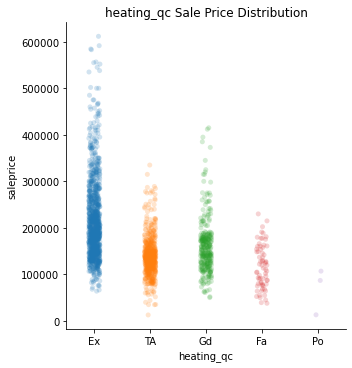

In [215]:
# plot it
sns.catplot(x = 'heating_qc', y = 'saleprice', data=train, alpha = 0.2)\
    .set(title = 'heating_qc Sale Price Distribution');

In [216]:
# make is heating_qc_Ex
train.heating_qc = train.heating_qc.map(lambda x: x == 'Ex').astype(int)
test.heating_qc = test.heating_qc.map(lambda x: x == 'Ex').astype(int)

train.rename(columns = {'heating_qc': 'is_heating_qc_Ex'}, inplace=True)
test.rename(columns = {'heating_qc': 'is_heating_qc_Ex'}, inplace=True)

train.iloc[[],10:20]

,bsmt_cond_is_TA_Gd_Ex,has_bsmt_exposure,bsmt_unf_sf,total_bsmt_sf,is_heating_qc_Ex,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf
pid,,,,,,,,,,


## Cols [15:25] --> [15,21] after cleaning

In [217]:
train.columns[15:25]

Index(['central_air', 'electrical', '1st_flr_sf', '2nd_flr_sf',
       'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath',
       'full_bath', 'half_bath'],
      dtype='object')

In [218]:
train.dtypes[15:25]

central_air         object
electrical          object
1st_flr_sf           int64
2nd_flr_sf           int64
low_qual_fin_sf      int64
gr_liv_area          int64
bsmt_full_bath     float64
bsmt_half_bath     float64
full_bath            int64
half_bath            int64
dtype: object

In [219]:
train.isnull().sum()[15:25]

central_air        0
electrical         0
1st_flr_sf         0
2nd_flr_sf         0
low_qual_fin_sf    0
gr_liv_area        0
bsmt_full_bath     2
bsmt_half_bath     2
full_bath          0
half_bath          0
dtype: int64

In [220]:
test.isnull().sum()[15:25]

central_air        0
electrical         1
1st_flr_sf         0
2nd_flr_sf         0
low_qual_fin_sf    0
gr_liv_area        0
bsmt_full_bath     0
bsmt_half_bath     0
full_bath          0
half_bath          0
dtype: int64

#### investigate `electrical` null

In [221]:
# investigate test electrical
test.electrical.unique()

array(['FuseP', 'SBrkr', 'FuseA', 'FuseF', nan], dtype=object)

In [222]:
# see most common in train
train.electrical.value_counts()

SBrkr    1864
FuseA     140
FuseF      35
FuseP       7
Mix         1
Name: electrical, dtype: int64

In [223]:
#impute with SBrkr
test.loc[916386080,'electrical'] = 'SBrkr'
test.loc[916386080,'electrical']

'SBrkr'

#### investigate `bsmt_full_bath` null

In [224]:
train[train.bsmt_full_bath.isnull()].has_basement

pid
908154080    0
903230120    0
Name: has_basement, dtype: int32

In [225]:
# impute with 0
train.bsmt_full_bath = train.bsmt_full_bath.map(lambda x: 0 if pd.isnull(x) else x)

#### investigate `bsmt_full_bath` nulls

In [226]:
train[train.bsmt_half_bath.isnull()].has_basement

pid
908154080    0
903230120    0
Name: has_basement, dtype: int32

In [227]:
# impute with 0
train.bsmt_half_bath = train.bsmt_half_bath.map(lambda x: 0 if pd.isnull(x) else x)

In [228]:
train.isnull().sum()[15:25]

central_air        0
electrical         0
1st_flr_sf         0
2nd_flr_sf         0
low_qual_fin_sf    0
gr_liv_area        0
bsmt_full_bath     0
bsmt_half_bath     0
full_bath          0
half_bath          0
dtype: int64

In [229]:
test.isnull().sum()[15:25]

central_air        0
electrical         0
1st_flr_sf         0
2nd_flr_sf         0
low_qual_fin_sf    0
gr_liv_area        0
bsmt_full_bath     0
bsmt_half_bath     0
full_bath          0
half_bath          0
dtype: int64

#### review `central_air`

In [230]:
train.central_air.unique()

array(['Y', 'N'], dtype=object)

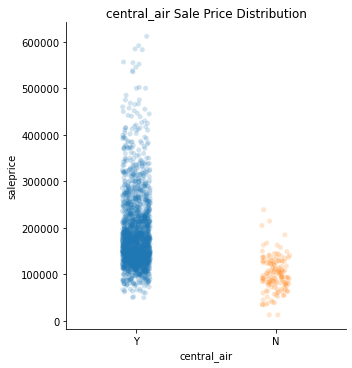

In [231]:
# plot
sns.catplot(x = 'central_air', y='saleprice', data=train, alpha=0.2)\
    .set(title = 'central_air Sale Price Distribution');

In [232]:
# dummy
train.central_air = train.central_air.map(lambda x: x == 'Y').astype(int)
test.central_air = test.central_air.map(lambda x: x == 'Y').astype(int)

train.rename(columns = {'central_air':'has_central_air'}, inplace=True)
test.rename(columns = {'central_air':'has_central_air'}, inplace=True)

train.iloc[[],15:25]

,has_central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath
pid,,,,,,,,,,


#### review `electrical`

In [233]:
train.electrical.value_counts(normalize=True)

SBrkr    0.910601
FuseA    0.068393
FuseF    0.017098
FuseP    0.003420
Mix      0.000489
Name: electrical, dtype: float64

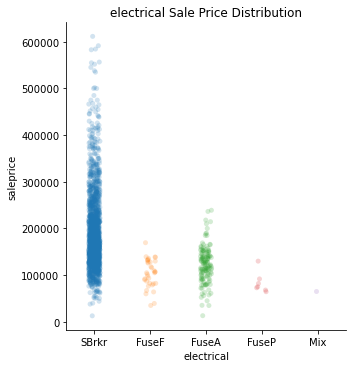

In [234]:
# plot
sns.catplot(x='electrical', y='saleprice', data=train, alpha=0.2)\
    .set(title = 'electrical Sale Price Distribution');

In [235]:
train.groupby('electrical').mean().saleprice

electrical
FuseA    122565.157143
FuseF    103678.914286
FuseP     83485.714286
Mix       67000.000000
SBrkr    187647.035408
Name: saleprice, dtype: float64

In [236]:
# dummy to is_SBrkr
train.electrical = train.electrical.map(lambda x: x == 'SBrkr').astype(int)
test.electrical = test.electrical.map(lambda x: x == 'SBrkr').astype(int)

train.rename(columns = {'electrical':'electrical_is_SBrkr'}, inplace=True)
test.rename(columns = {'electrical':'electrical_is_SBrkr'}, inplace=True)

train.iloc[[],15:25]

,has_central_air,electrical_is_SBrkr,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath
pid,,,,,,,,,,


#### review `1st_flr_sf`

In [237]:
train['1st_flr_sf'].describe()

count    2047.000000
mean     1161.864191
std       388.250063
min       334.000000
25%       879.000000
50%      1092.000000
75%      1402.500000
max      5095.000000
Name: 1st_flr_sf, dtype: float64

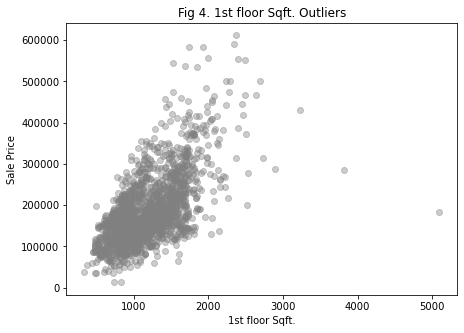

In [238]:
# plot it
figure, ax = plt.subplots(1, 1, figsize=(7,5))

ax.scatter(train['1st_flr_sf'], train.saleprice, color='grey', alpha=0.4)
ax.set_title('Fig 4. 1st floor Sqft. Outliers')
ax.set_xlabel('1st floor Sqft.')
ax.set_ylabel('Sale Price');

In [239]:
# drop two outliers
train = train[train['1st_flr_sf']<=3500]

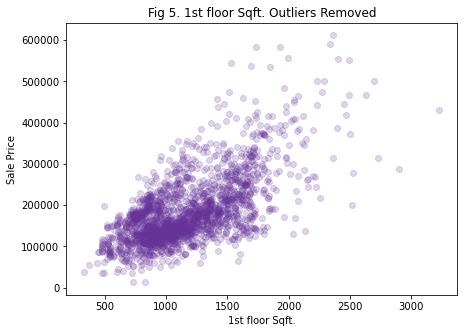

In [240]:
#plot it
figure, ax = plt.subplots(1, 1, figsize=(7,5))

ax.scatter(train['1st_flr_sf'], train.saleprice, color='rebeccapurple', alpha=0.2)
ax.set_title('Fig 5. 1st floor Sqft. Outliers Removed')
ax.set_xlabel('1st floor Sqft.')
ax.set_ylabel('Sale Price');

#### review `2nd_flr_sf`

In [241]:
train['2nd_flr_sf'].describe()

count    2045.000000
mean      329.488509
std       425.746127
min         0.000000
25%         0.000000
50%         0.000000
75%       691.000000
max      1862.000000
Name: 2nd_flr_sf, dtype: float64

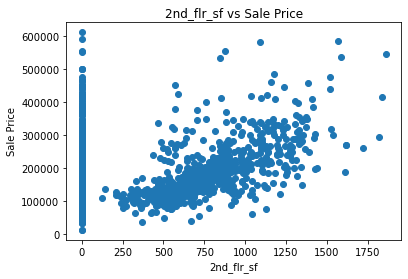

In [242]:
# plot it
plt.scatter(train['2nd_flr_sf'], train.saleprice)
plt.title('2nd_flr_sf vs Sale Price')
plt.xlabel('2nd_flr_sf')
plt.ylabel('Sale Price');

In [243]:
train['2nd_flr_sf'].value_counts(normalize=True)

0      0.580440
728    0.007335
504    0.006846
546    0.005868
600    0.004890
         ...   
581    0.000489
220    0.000489
679    0.000489
841    0.000489
776    0.000489
Name: 2nd_flr_sf, Length: 503, dtype: float64

In [244]:
# create dummy for has 2nd_flr_sf
has_2nd_flr = train['2nd_flr_sf'].map(lambda x: x>0).astype(int)
test_has_2nd_flr = test['2nd_flr_sf'].map(lambda x: x>0).astype(int)

train = train.join(has_2nd_flr.rename('has_2nd_flr'))
test = test.join(test_has_2nd_flr.rename('has_2nd_flr'))

train.iloc[[],-5:]

,bsmt_ALQ_sf,bsmt_BLQ_sf,bsmt_LwQ_sf,bsmt_Rec_sf,has_2nd_flr
pid,,,,,


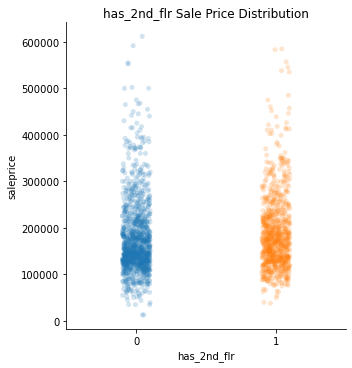

In [245]:
#plot it
sns.catplot(x = 'has_2nd_flr', y = 'saleprice', data=train, alpha=0.2)\
    .set(title = 'has_2nd_flr Sale Price Distribution');

In [246]:
train.groupby('has_2nd_flr').mean().saleprice

has_2nd_flr
0    175926.947767
1    188717.390443
Name: saleprice, dtype: float64

**Observation** slightly different distributions. Keep the dummy.

#### review `low_qual_fin_sf`

In [247]:
train.low_qual_fin_sf.value_counts(normalize=True)

0       0.983863
80      0.001467
205     0.000978
512     0.000489
362     0.000489
53      0.000489
360     0.000489
384     0.000489
156     0.000489
436     0.000489
259     0.000489
479     0.000489
140     0.000489
397     0.000489
514     0.000489
144     0.000489
697     0.000489
114     0.000489
390     0.000489
234     0.000489
572     0.000489
312     0.000489
120     0.000489
515     0.000489
1064    0.000489
108     0.000489
473     0.000489
371     0.000489
513     0.000489
528     0.000489
450     0.000489
Name: low_qual_fin_sf, dtype: float64

In [248]:
#  drop the column ... too many zeroes
train.drop('low_qual_fin_sf', axis = 1, inplace=True)
test.drop('low_qual_fin_sf', axis = 1, inplace=True)

train.iloc[[],15:25]

,has_central_air,electrical_is_SBrkr,1st_flr_sf,2nd_flr_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr
pid,,,,,,,,,,


#### review `gr_liv_area`

In [249]:
train.gr_liv_area.describe()

count    2045.000000
mean     1493.658680
std       483.095392
min       334.000000
25%      1128.000000
50%      1442.000000
75%      1728.000000
max      3672.000000
Name: gr_liv_area, dtype: float64

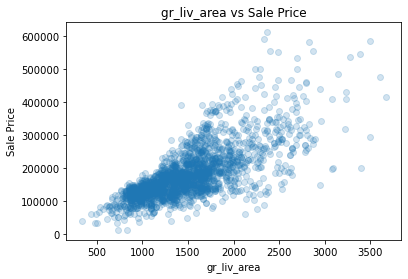

In [250]:
# plot
plt.scatter(train.gr_liv_area, train.saleprice, alpha=0.2)
plt.title('gr_liv_area vs Sale Price')
plt.xlabel('gr_liv_area')
plt.ylabel('Sale Price');

**Observation**
  *  Love it! This will be great for modeling

#### review `bsmt_full_bath`

In [251]:
train.bsmt_full_bath.value_counts(normalize = True)

0.0    0.586797
1.0    0.401467
2.0    0.010758
3.0    0.000978
Name: bsmt_full_bath, dtype: float64

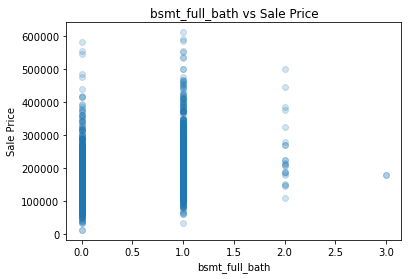

In [252]:
# plot
plt.scatter(train.bsmt_full_bath, train.saleprice, alpha=0.2)
plt.title('bsmt_full_bath vs Sale Price')
plt.xlabel('bsmt_full_bath')
plt.ylabel('Sale Price');

#### review `bsmt_half_bath`

In [253]:
train.bsmt_half_bath.value_counts(normalize = True)

0.0    0.939364
1.0    0.058680
2.0    0.001956
Name: bsmt_half_bath, dtype: float64

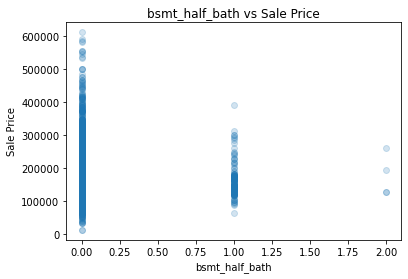

In [254]:
# plot
plt.scatter(train.bsmt_half_bath, train.saleprice, alpha=0.2)
plt.title('bsmt_half_bath vs Sale Price')
plt.xlabel('bsmt_half_bath')
plt.ylabel('Sale Price');

#### review `bsmt_half_bath`

In [255]:
train.full_bath.value_counts()

2    1091
1     900
3      44
0       8
4       2
Name: full_bath, dtype: int64

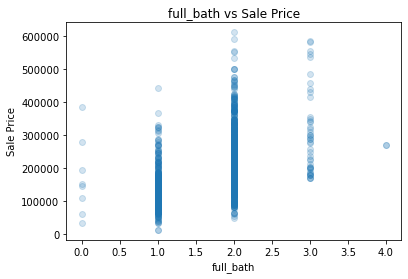

In [256]:
# plot
plt.scatter(train.full_bath, train.saleprice, alpha=0.2)
plt.title('full_bath vs Sale Price')
plt.xlabel('full_bath')
plt.ylabel('Sale Price');

#### review `full_bath`

In [257]:
train.half_bath.value_counts()

0    1305
1     722
2      18
Name: half_bath, dtype: int64

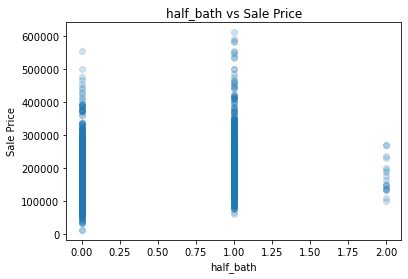

In [258]:
# plot
plt.scatter(train.half_bath, train.saleprice, alpha=0.2)
plt.title('half_bath vs Sale Price')
plt.xlabel('half_bath')
plt.ylabel('Sale Price');

**Observations**: bsmt baths don't seem positively correlated. full_bath does with half_bath somewhat. Investigate a total bath variable.

In [259]:
# create total full baths
train['total_full_baths'] = train.bsmt_full_bath + train.full_bath
test['total_full_baths'] = test.bsmt_full_bath + test.full_bath

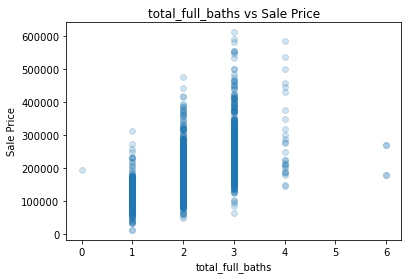

In [260]:
# plot
plt.scatter(train.total_full_baths, train.saleprice, alpha=0.2)
plt.title('total_full_baths vs Sale Price')
plt.xlabel('total_full_baths')
plt.ylabel('Sale Price');

In [261]:
# drop outliers
train = train[train.total_full_baths < 6]

In [262]:
# create total half baths
train['total_half_baths'] = train.bsmt_half_bath + train.half_bath
test['total_half_baths'] = test.bsmt_half_bath + test.half_bath

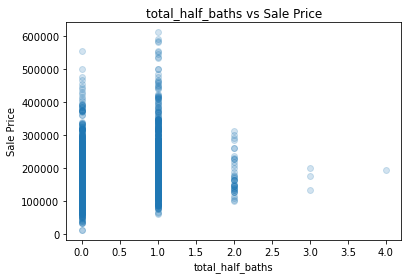

In [263]:
# plot
plt.scatter(train.total_half_baths, train.saleprice, alpha=0.2)
plt.title('total_half_baths vs Sale Price')
plt.xlabel('total_half_baths')
plt.ylabel('Sale Price');

In [264]:
# total baths?
train['total_baths'] = train.total_full_baths + train.total_half_baths
test['total_baths'] = test.total_full_baths + test.total_half_baths

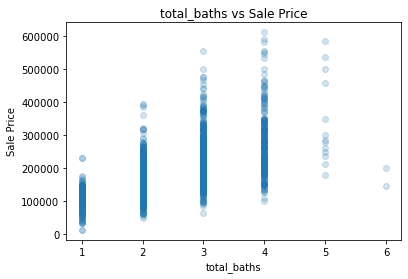

In [265]:
# plot
plt.scatter(train.total_baths, train.saleprice, alpha=0.2)
plt.title('total_baths vs Sale Price')
plt.xlabel('total_baths')
plt.ylabel('Sale Price');

In [266]:
# drop outliers
train = train[train.total_baths < 6]

**Observation** pretty good positive trend with saleprice for `total_baths`

In [267]:
# drop bsmt_full_bath, bsmt_half_bath, half_bath, total_half_baths
# keep full_bath, total_full_baths, total_baths

train.drop(['bsmt_full_bath','bsmt_half_bath','half_bath','total_half_baths'],
           axis = 1,
           inplace = True)

test.drop(['bsmt_full_bath','bsmt_half_bath','half_bath','total_half_baths'],
           axis = 1,
           inplace = True)

train.iloc[[],5:15]

,is_land_slope_mod,overall_qual,mas_vnr_area,exter_qual_Ex_Gd,bsmt_qual_Ex_Gd,bsmt_cond_is_TA_Gd_Ex,has_bsmt_exposure,bsmt_unf_sf,total_bsmt_sf,is_heating_qc_Ex
pid,,,,,,,,,,


### Cols [21:31] --> [21,28] after cleaning

In [268]:
train.columns[21:31]

Index(['bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd',
       'functional', 'fireplaces', 'fireplace_qu', 'garage_type',
       'garage_yr_blt', 'garage_finish'],
      dtype='object')

In [269]:
train.dtypes[21:31]

bedroom_abvgr      int64
kitchen_abvgr      int64
kitchen_qual      object
totrms_abvgrd      int64
functional        object
fireplaces         int64
fireplace_qu      object
garage_type       object
garage_yr_blt    float64
garage_finish     object
dtype: object

In [270]:
# check nulls
train.isnull().sum()[21:31]

bedroom_abvgr      0
kitchen_abvgr      0
kitchen_qual       0
totrms_abvgrd      0
functional         0
fireplaces         0
fireplace_qu     996
garage_type      110
garage_yr_blt    111
garage_finish    111
dtype: int64

In [271]:
test.isnull().sum()[21:31]

bedroom_abvgr      0
kitchen_abvgr      0
kitchen_qual       0
totrms_abvgrd      0
functional         0
fireplaces         0
fireplace_qu     422
garage_type       44
garage_yr_blt     45
garage_finish     45
dtype: int64

#### investigate `fireplace_qu` nulls

In [272]:
train.fireplace_qu.unique()

array([nan, 'TA', 'Gd', 'Po', 'Ex', 'Fa'], dtype=object)

In [273]:
# review number of fireplaces for null fireplace_qu
train[train.fireplace_qu.isnull()].fireplaces.unique()

array([0], dtype=int64)

In [274]:
# impute with 'NA'
train.fireplace_qu = train.fireplace_qu.map(lambda x: 'NA' if pd.isnull(x) else x)
test.fireplace_qu = test.fireplace_qu.map(lambda x: 'NA' if pd.isnull(x) else x)

#### investigate `garage_type` nulls

In [275]:
train.garage_type.unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'Basment', nan, '2Types', 'CarPort'],
      dtype=object)

In [276]:
# review garage yr built for null garage type
train[train.garage_type.isnull()].garage_yr_blt.unique()

array([nan])

In [277]:
# impute with 'NA'
train.garage_type = train.garage_type.map(lambda x: 'NA' if pd.isnull(x) else x)
test.garage_type = test.garage_type.map(lambda x: 'NA' if pd.isnull(x) else x)

#### investigate `garage_yr_blt` nulls

In [278]:
train.garage_yr_blt.unique()

array([1976., 1997., 1953., 2007., 1957., 1966., 2005., 1959., 1952.,
       1969., 1971., 1900., 2000., 2004., 1916., 1963., 1977., 2009.,
       1968., 1992., 1955., 1961., 1973., 1937.,   nan, 2003., 1981.,
       1931., 1995., 1958., 1965., 2006., 1978., 1954., 1935., 1951.,
       1996., 1999., 1920., 1930., 1924., 1960., 1949., 1986., 1956.,
       1994., 1979., 1964., 2001., 1972., 1939., 1962., 1927., 1948.,
       1967., 1993., 2010., 1915., 1987., 1970., 1988., 1982., 1941.,
       1984., 1942., 1950., 2002., 1975., 2008., 1974., 1998., 1918.,
       1938., 1985., 1923., 1980., 1991., 1946., 1940., 1990., 1896.,
       1983., 1914., 1945., 1921., 1925., 1926., 1936., 1932., 1947.,
       1929., 1910., 1917., 1922., 1934., 1989., 1928., 2207., 1933.,
       1895., 1919.])

In [279]:
# find nulls that have a garage type
train[(train.garage_yr_blt.isnull())&(train.garage_type != 'NA')].garage_type

pid
910201180    Detchd
Name: garage_type, dtype: object

In [280]:
# look at house built vs garage built
# create garage age
garage_age = train.garage_yr_blt.map(lambda x: 2010 - x if ~pd.isnull(x) else x)
test_garage_age = test.garage_yr_blt.map(lambda x: 2010 - x if ~pd.isnull(x) else x)

garage_age.rename('garage_age', inplace=True)
test_garage_age.rename('garage_age', inplace=True)

train = train.join(garage_age)
test = test.join(test_garage_age)

In [281]:
# compare house age to garage age
pd.Series(train.home_age - train.garage_age).describe()

count    1928.000000
mean        5.317946
std        16.590650
min       -15.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       201.000000
dtype: float64

In [282]:
train.garage_yr_blt.describe()

count    1928.000000
mean     1978.695021
std        25.460274
min      1895.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2207.000000
Name: garage_yr_blt, dtype: float64

In [283]:
# garage_yr_blt has an outlier at 2207
# make year 2207 null
train.loc[916384070,'garage_yr_blt'] = np.nan


In [284]:
train.garage_yr_blt.describe()

count    1927.000000
mean     1978.576544
std        24.929605
min      1895.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: garage_yr_blt, dtype: float64

In [285]:
# retry comparison garage_age
pd.Series(train.home_age - train.garage_age).describe()

count    1928.000000
mean        5.317946
std        16.590650
min       -15.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       201.000000
dtype: float64

In [286]:
# review nulls again
train[(train.garage_yr_blt.isnull())&(train.garage_type != 'NA')].garage_type

pid
916384070    Attchd
910201180    Detchd
Name: garage_type, dtype: object

In [287]:
# imput with garage date 5 years beyond yr house built
train.loc[916384070,'garage_yr_blt'] = 2010
train.loc[910201180,'garage_yr_blt'] = 1928
train.loc[[916384070,910201180], 'garage_yr_blt']

pid
916384070    2010.0
910201180    1928.0
Name: garage_yr_blt, dtype: float64

In [288]:
test[(test.garage_yr_blt.isnull())&(test.garage_type != 'NA')].garage_type

pid
903426160    Detchd
Name: garage_type, dtype: object

In [289]:
# impute with 5 years
test.loc[903426160,'garage_yr_blt'] = 1915
test.loc[903426160,'garage_yr_blt']


1915.0

#### review `garage_fin`

In [290]:
train[train.garage_finish.isnull()].garage_yr_blt.value_counts()

1928.0    1
Name: garage_yr_blt, dtype: int64

In [291]:
test[test.garage_finish.isnull()].garage_yr_blt.value_counts()

1915.0    1
Name: garage_yr_blt, dtype: int64

In [292]:
# impute by most common
train.garage_finish.value_counts()

Unf    846
RFn    578
Fin    504
Name: garage_finish, dtype: int64

In [293]:
train.loc[910201180,'garage_finish'] = 'Unf'
train[train.garage_finish.isnull()].garage_yr_blt.value_counts()

Series([], Name: garage_yr_blt, dtype: int64)

In [294]:
test[(test.garage_finish.isnull())&(test.garage_yr_blt == 1915)]

,lot_frontage,lot_area,has_alley,is_lot_shape_regluar,is_land_countour_hls,is_land_slope_mod,overall_qual,mas_vnr_area,exter_qual_Ex_Gd,bsmt_qual_Ex_Gd,...,foundation_CBlock,bsmt_GLQ_sf,bsmt_ALQ_sf,bsmt_BLQ_sf,bsmt_LwQ_sf,bsmt_Rec_sf,has_2nd_flr,total_full_baths,total_baths,garage_age
pid,,,,,,,,,,,,,,,,,,,,,
903426160,57.0,8094,1,1,0,0,6,0.0,0,0,...,0,0,0,0,0,196,1,2,2,NaN


In [295]:
# impute with Unf
test.loc[903426160,'garage_finish'] = 'Unf'
test[test.garage_finish.isnull()].garage_yr_blt.value_counts()

Series([], Name: garage_yr_blt, dtype: int64)

In [296]:
train.isnull().sum()[21:31]

bedroom_abvgr      0
kitchen_abvgr      0
kitchen_qual       0
totrms_abvgrd      0
functional         0
fireplaces         0
fireplace_qu       0
garage_type        0
garage_yr_blt    110
garage_finish    110
dtype: int64

In [297]:
test.isnull().sum()[21:31]

bedroom_abvgr     0
kitchen_abvgr     0
kitchen_qual      0
totrms_abvgrd     0
functional        0
fireplaces        0
fireplace_qu      0
garage_type       0
garage_yr_blt    44
garage_finish    44
dtype: int64

In [298]:
# finalize imputation with garage_finish NA, keep garage yr null
train.garage_finish = train.garage_finish.map(lambda x: 'NA' if pd.isnull(x) else x)
test.garage_finish = test.garage_finish.map(lambda x: 'NA' if pd.isnull(x) else x)

In [299]:
train.isnull().sum()[21:31]

bedroom_abvgr      0
kitchen_abvgr      0
kitchen_qual       0
totrms_abvgrd      0
functional         0
fireplaces         0
fireplace_qu       0
garage_type        0
garage_yr_blt    110
garage_finish      0
dtype: int64

In [300]:
test.isnull().sum()[21:31]

bedroom_abvgr     0
kitchen_abvgr     0
kitchen_qual      0
totrms_abvgrd     0
functional        0
fireplaces        0
fireplace_qu      0
garage_type       0
garage_yr_blt    44
garage_finish     0
dtype: int64

#### review `bedroom_abvgr`

In [301]:
train.bedroom_abvgr.value_counts(normalize=True)

3    0.541932
2    0.265817
4    0.128494
1    0.036783
5    0.019617
6    0.004414
0    0.002452
8    0.000490
Name: bedroom_abvgr, dtype: float64

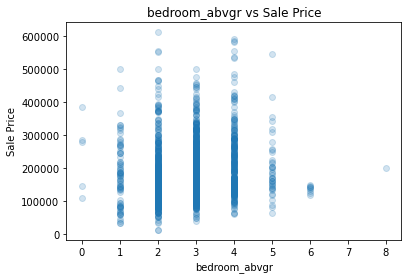

In [302]:
# plot it
plt.scatter(train.bedroom_abvgr, train.saleprice, alpha = 0.2)
plt.title('bedroom_abvgr vs Sale Price')
plt.xlabel('bedroom_abvgr')
plt.ylabel('Sale Price');

#### review `kitchen_abvgr`

In [303]:
train.kitchen_abvgr.value_counts(normalize=True)

1    0.957332
2    0.041197
0    0.000981
3    0.000490
Name: kitchen_abvgr, dtype: float64

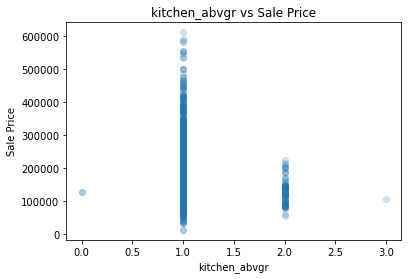

In [304]:
# plot it
plt.scatter(train.kitchen_abvgr, train.saleprice, alpha = 0.2)
plt.title('kitchen_abvgr vs Sale Price')
plt.xlabel('kitchen_abvgr')
plt.ylabel('Sale Price');

**Observation** Not a good correlation. Drop it.

In [305]:
# drop column
train.drop('kitchen_abvgr', axis = 1, inplace=True)
test.drop('kitchen_abvgr', axis = 1, inplace=True)

train.iloc[[],21:31]

,bedroom_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars
pid,,,,,,,,,,


#### review `kitchenqual`

In [306]:
train.kitchen_qual.value_counts(normalize=True)

TA    0.510544
Gd    0.393821
Ex    0.072585
Fa    0.023051
Name: kitchen_qual, dtype: float64

<Figure size 720x720 with 0 Axes>

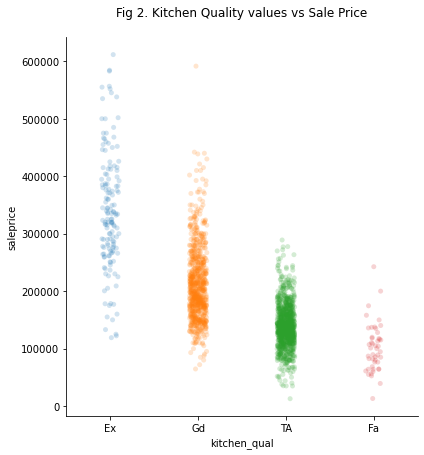

In [307]:
# plot it
plt.figure(figsize=(10,10))

ax = sns.catplot(x = 'kitchen_qual', y='saleprice', data=train, alpha = 0.2,
                 height = 6,
           order = ['Ex','Gd','TA','Fa']);
ax.set(title='Fig 2. Kitchen Quality values vs Sale Price\n');

**Observation** Ex and Gd form good bands

In [308]:
# dummy
train.kitchen_qual = train.kitchen_qual.map(lambda x: x == 'Ex' or x == 'Gd').astype(int)
test.kitchen_qual = test.kitchen_qual.map(lambda x: x == 'Ex' or x == 'Gd').astype(int)

train.rename(columns = {'kitchen_qual': 'kitchen_qual_Ex_Gd'}, inplace=True)
test.rename(columns = {'kitchen_qual': 'kitchen_qual_Ex_Gd'}, inplace=True)

train.iloc[[],21:31]

,bedroom_abvgr,kitchen_qual_Ex_Gd,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars
pid,,,,,,,,,,


#### review `totrms_abvgrd`

In [309]:
train.totrms_abvgrd.unique()
train.totrms_abvgrd.value_counts(normalize=True)

6     0.292791
7     0.232467
5     0.198136
8     0.110839
4     0.071604
9     0.047082
10    0.024031
11    0.010299
3     0.005885
12    0.005395
14    0.000490
2     0.000490
13    0.000490
Name: totrms_abvgrd, dtype: float64

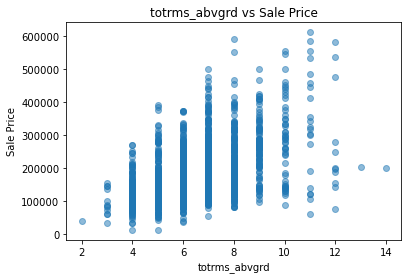

In [310]:
# plot it
plt.scatter(x = train.totrms_abvgrd, y = train.saleprice, alpha = 0.5)
plt.title('totrms_abvgrd vs Sale Price')
plt.xlabel('totrms_abvgrd')
plt.ylabel('Sale Price');

#### review `functional`

In [311]:
train.functional.value_counts(normalize=True)

Typ     0.933301
Min2    0.020598
Min1    0.020598
Mod     0.014223
Maj1    0.005885
Maj2    0.003433
Sev     0.000981
Sal     0.000981
Name: functional, dtype: float64

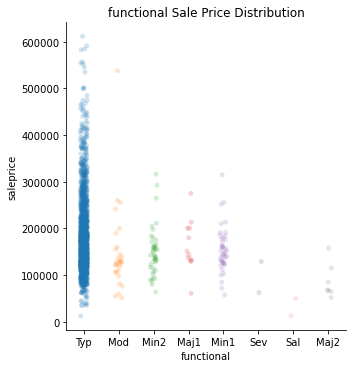

In [312]:
# plot it
sns.catplot(x = 'functional', y='saleprice', data=train, alpha = 0.2)\
    .set(title = 'functional Sale Price Distribution');

In [313]:
train.groupby('functional').mean().saleprice

functional
Maj1    163106.166667
Maj2     87157.714286
Min1    154429.761905
Min2    150424.571429
Mod     148108.724138
Sal      31550.000000
Sev      95750.000000
Typ     183699.892275
Name: saleprice, dtype: float64

In [314]:
# dummy for is_typical
train.functional = train.functional.map(lambda x: x == 'Typ').astype(int)
test.functional = test.functional.map(lambda x: x == 'Typ').astype(int)

train.rename(columns = {'functional': 'is_functional'}, inplace = True)
test.rename(columns = {'functional': 'is_functional'}, inplace = True)


train.iloc[[],21:31]

,bedroom_abvgr,kitchen_qual_Ex_Gd,totrms_abvgrd,is_functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars
pid,,,,,,,,,,


#### review `fireplaces`

In [315]:
train.fireplaces.value_counts(normalize=True)

0    0.488475
1    0.439922
2    0.068661
3    0.002452
4    0.000490
Name: fireplaces, dtype: float64

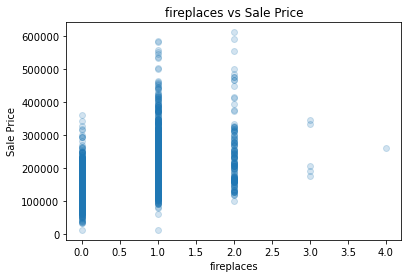

In [316]:
# plot it
plt.scatter(x = train.fireplaces, y=train.saleprice, alpha = 0.2)
plt.title('fireplaces vs Sale Price')
plt.xlabel('fireplaces')
plt.ylabel('Sale Price');

In [317]:
# dummy to has fireplace
train.fireplaces = train.fireplaces.map(lambda x: x != 0).astype(int)
test.fireplaces = test.fireplaces.map(lambda x: x != 0).astype(int)


train.rename(columns = {'fireplaces': 'has_fireplace'}, inplace = True)
test.rename(columns = {'fireplaces': 'has_fireplace'}, inplace = True)

train.iloc[[],21:31]

,bedroom_abvgr,kitchen_qual_Ex_Gd,totrms_abvgrd,is_functional,has_fireplace,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars
pid,,,,,,,,,,


#### review `fireplace_qu`

In [318]:
train.fireplace_qu.value_counts(normalize=True)

NA    0.488475
Gd    0.254537
TA    0.197646
Fa    0.028936
Po    0.015204
Ex    0.015204
Name: fireplace_qu, dtype: float64

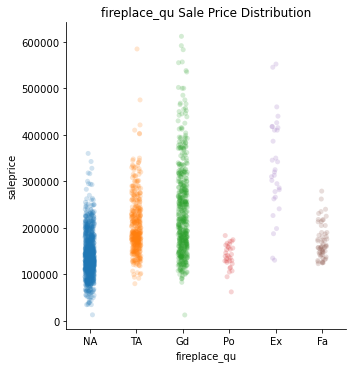

In [319]:
# plot it
sns.catplot(x = 'fireplace_qu', y='saleprice', data=train, alpha = 0.2)\
    .set(title = 'fireplace_qu Sale Price Distribution');

In [320]:
# dummy to fireplace_qu_Ex_Gd
train.fireplace_qu = train.fireplace_qu.map(lambda x: x == 'Ex' or x == 'Gd').astype(int)
test.fireplace_qu = test.fireplace_qu.map(lambda x: x == 'Ex' or x == 'Gd').astype(int)

train.rename(columns = {'fireplace_qu': 'fireplace_qu_Ex_Gd'}, inplace=True)
test.rename(columns = {'fireplace_qu': 'fireplace_qu_Ex_Gd'}, inplace=True)

train.iloc[[],21:31]

,bedroom_abvgr,kitchen_qual_Ex_Gd,totrms_abvgrd,is_functional,has_fireplace,fireplace_qu_Ex_Gd,garage_type,garage_yr_blt,garage_finish,garage_cars
pid,,,,,,,,,,


#### review `garage_type`

In [321]:
train.garage_type.value_counts(normalize=True)

Attchd     0.591957
Detchd     0.262384
BuiltIn    0.063757
NA         0.053948
Basment    0.013242
2Types     0.009318
CarPort    0.005395
Name: garage_type, dtype: float64

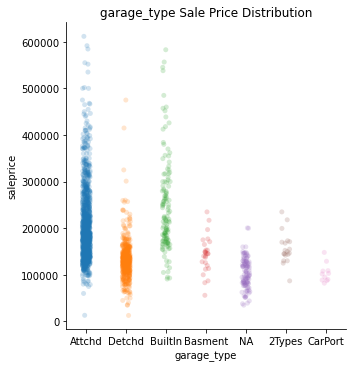

In [322]:
# plot it
sns.catplot(x = 'garage_type', y = 'saleprice', data=train, alpha=0.2)\
    .set(title = 'garage_type Sale Price Distribution');

In [323]:
# create dummy attchd or builtin
train.garage_type = train.garage_type.map(lambda x: x == 'Attchd' or x == 'BuiltIn').astype(int)
test.garage_type = test.garage_type.map(lambda x: x == 'Attchd' or x == 'BuiltIn').astype(int)

train.rename(columns = {'garage_type': 'garage_type_Attchd_BuiltIn'}, inplace=True)
test.rename(columns = {'garage_type': 'garage_type_Attchd_BuiltIn'}, inplace=True)


train.iloc[[],21:31]

,bedroom_abvgr,kitchen_qual_Ex_Gd,totrms_abvgrd,is_functional,has_fireplace,fireplace_qu_Ex_Gd,garage_type_Attchd_BuiltIn,garage_yr_blt,garage_finish,garage_cars
pid,,,,,,,,,,


#### review `garage_yr_blt`

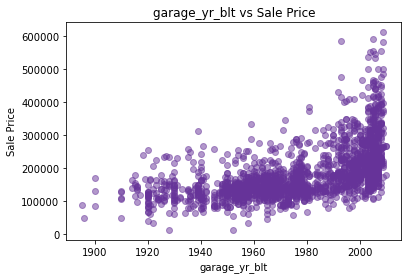

In [324]:
plt.scatter(x = train.garage_yr_blt, y = train.saleprice, alpha = 0.5, color = 'rebeccapurple')
plt.title('garage_yr_blt vs Sale Price')
plt.xlabel('garage_yr_blt')
plt.ylabel('Sale Price');

In [325]:
# investigate upward lift on the right
train.groupby(pd.cut(train.garage_yr_blt, bins = range(1880, 2011, 5))).mean().saleprice\
              > train.saleprice.describe()['mean']+train.saleprice.describe()['std']

garage_yr_blt
(1880, 1885]    False
(1885, 1890]    False
(1890, 1895]    False
(1895, 1900]    False
(1900, 1905]    False
(1905, 1910]    False
(1910, 1915]    False
(1915, 1920]    False
(1920, 1925]    False
(1925, 1930]    False
(1930, 1935]    False
(1935, 1940]    False
(1940, 1945]    False
(1945, 1950]    False
(1950, 1955]    False
(1955, 1960]    False
(1960, 1965]    False
(1965, 1970]    False
(1970, 1975]    False
(1975, 1980]    False
(1980, 1985]    False
(1985, 1990]    False
(1990, 1995]    False
(1995, 2000]    False
(2000, 2005]    False
(2005, 2010]     True
Name: saleprice, dtype: bool

In [326]:
# bin into garage >= 2006 and has garage
garage_new_2006 = train.garage_yr_blt.map(lambda x: x > 2005).astype(int).rename('garage_new_2006')
has_garage = train.garage_yr_blt.map(lambda x: 0 if pd.isnull(x) else 1).rename('has_garage')

test_garage_new_2006 = test.garage_yr_blt.map(lambda x: x > 2005).astype(int).rename('garage_new_2006')
test_has_garage = test.garage_yr_blt.map(lambda x: 0 if pd.isnull(x) else 1).rename('has_garage')


train = train.join([garage_new_2006,has_garage])
test = test.join([test_garage_new_2006,test_has_garage])

train.iloc[[],-5:]

,total_full_baths,total_baths,garage_age,garage_new_2006,has_garage
pid,,,,,


In [327]:
# drop garage_yr_blt, garage_age
train.drop(['garage_yr_blt','garage_age'], axis = 1, inplace=True)
test.drop(['garage_yr_blt','garage_age'], axis = 1, inplace=True)


train.iloc[[],21:31]

,bedroom_abvgr,kitchen_qual_Ex_Gd,totrms_abvgrd,is_functional,has_fireplace,fireplace_qu_Ex_Gd,garage_type_Attchd_BuiltIn,garage_finish,garage_cars,garage_area
pid,,,,,,,,,,


#### review `garage_finish`

In [328]:
train.garage_finish.value_counts(normalize=True)

Unf    0.415400
RFn    0.283472
Fin    0.247180
NA     0.053948
Name: garage_finish, dtype: float64

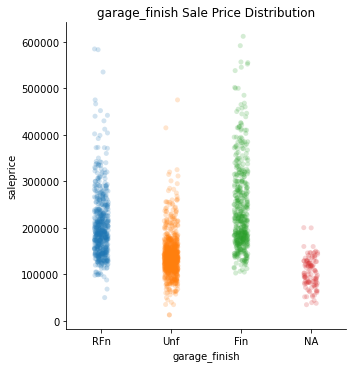

In [329]:
# plot
sns.catplot(x = 'garage_finish', y = 'saleprice', data=train, alpha=0.2)\
    .set(title = 'garage_finish Sale Price Distribution');

In [330]:
# dummy it
train = train.join(pd.get_dummies(train.garage_finish, prefix = 'garage_finish')\
                .loc[:,['garage_finish_RFn','garage_finish_Unf','garage_finish_Fin']])
test = test.join(pd.get_dummies(test.garage_finish, prefix = 'garage_finish')\
                .loc[:,['garage_finish_RFn','garage_finish_Unf','garage_finish_Fin']])


train.iloc[[],-5:]

,garage_new_2006,has_garage,garage_finish_RFn,garage_finish_Unf,garage_finish_Fin
pid,,,,,


In [331]:
# drop garage_finish
train.drop('garage_finish', axis=1, inplace=True)
test.drop('garage_finish', axis=1, inplace=True)

train.iloc[[],21:31]

,bedroom_abvgr,kitchen_qual_Ex_Gd,totrms_abvgrd,is_functional,has_fireplace,fireplace_qu_Ex_Gd,garage_type_Attchd_BuiltIn,garage_cars,garage_area,garage_qual
pid,,,,,,,,,,


## Col [26:36] --> [26,33] after cleaning

In [332]:
train.columns[26:36]

Index(['fireplace_qu_Ex_Gd', 'garage_type_Attchd_BuiltIn', 'garage_cars',
       'garage_area', 'garage_qual', 'garage_cond', 'paved_drive',
       'wood_deck_sf', 'open_porch_sf', 'enclosed_porch'],
      dtype='object')

In [333]:
train.dtypes[26:36]

fireplace_qu_Ex_Gd              int32
garage_type_Attchd_BuiltIn      int32
garage_cars                   float64
garage_area                   float64
garage_qual                    object
garage_cond                    object
paved_drive                    object
wood_deck_sf                    int64
open_porch_sf                   int64
enclosed_porch                  int64
dtype: object

In [334]:
train.isnull().sum()[26:36]

fireplace_qu_Ex_Gd              0
garage_type_Attchd_BuiltIn      0
garage_cars                     1
garage_area                     1
garage_qual                   111
garage_cond                   111
paved_drive                     0
wood_deck_sf                    0
open_porch_sf                   0
enclosed_porch                  0
dtype: int64

In [335]:
test.isnull().sum()[26:36]

fireplace_qu_Ex_Gd             0
garage_type_Attchd_BuiltIn     0
garage_cars                    0
garage_area                    0
garage_qual                   45
garage_cond                   45
paved_drive                    0
wood_deck_sf                   0
open_porch_sf                  0
enclosed_porch                 0
dtype: int64

#### investigate `garage_cars` null

In [336]:
train.garage_cars.map(lambda x: -1 if pd.isnull(x) else x).value_counts(normalize=True)

 2.0    0.554684
 1.0    0.256989
 3.0    0.128494
 0.0    0.053948
 4.0    0.004904
 5.0    0.000490
-1.0    0.000490
Name: garage_cars, dtype: float64

In [337]:
train[train.garage_cars.isnull()].has_garage

pid
910201180    1
Name: has_garage, dtype: int64

In [338]:
# impute with mean
train.loc[910201180,'garage_cars'] = round(train.garage_cars.describe()['mean'],0)

In [339]:
# this record as null garage_area, impute with mean
train.loc[910201180,'garage_area'] = round(train.garage_area.describe()['mean'],0)

In [340]:
# this record also has null garage_qual and garage_cond
train.loc[910201180,['garage_qual','garage_cond']]

garage_qual    NaN
garage_cond    NaN
Name: 910201180, dtype: object

In [341]:
# impute with the most common
train.loc[910201180,'garage_qual'] = 'TA'
train.loc[910201180,'garage_cond'] = 'TA'

In [342]:
train.isnull().sum()[26:36]

fireplace_qu_Ex_Gd              0
garage_type_Attchd_BuiltIn      0
garage_cars                     0
garage_area                     0
garage_qual                   110
garage_cond                   110
paved_drive                     0
wood_deck_sf                    0
open_porch_sf                   0
enclosed_porch                  0
dtype: int64

#### review `garage_cars`

In [343]:
train.garage_cars.value_counts(normalize=True)

2.0    0.555174
1.0    0.256989
3.0    0.128494
0.0    0.053948
4.0    0.004904
5.0    0.000490
Name: garage_cars, dtype: float64

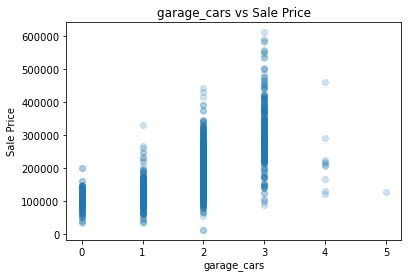

In [344]:
# plot it
plt.scatter(x = train.garage_cars, y=train.saleprice, alpha=0.2)
plt.title('garage_cars vs Sale Price')
plt.xlabel('garage_cars')
plt.ylabel('Sale Price');

#### review `garage_area`

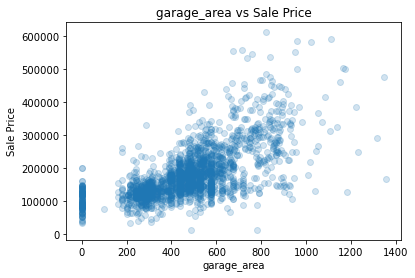

In [345]:
plt.scatter(x = train.garage_area, y=train.saleprice, alpha=0.2)
plt.title('garage_area vs Sale Price')
plt.xlabel('garage_area')
plt.ylabel('Sale Price');

#### review `garage_qual`

In [346]:
train.garage_qual.unique()

array(['TA', 'Fa', nan, 'Gd', 'Ex', 'Po'], dtype=object)

In [347]:
# check nulls against has_garage
train[train.garage_qual.isnull()].has_garage.value_counts()

0    110
Name: has_garage, dtype: int64

In [348]:
# impute with 'NA'
train.garage_qual = train.garage_qual.map(lambda x: 'NA' if pd.isnull(x) else x)
test.garage_qual = test.garage_qual.map(lambda x: 'NA' if pd.isnull(x) else x)

In [349]:
train.garage_qual.value_counts(normalize=True)

TA    0.894556
NA    0.053948
Fa    0.040216
Gd    0.008828
Ex    0.001471
Po    0.000981
Name: garage_qual, dtype: float64

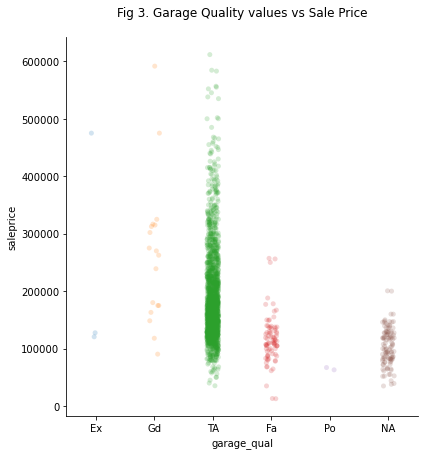

In [350]:
#plot it
sns.catplot(x = 'garage_qual', y='saleprice', data=train, alpha=0.2,
            height = 6,
           order = ['Ex','Gd','TA','Fa','Po','NA'])\
    .set(title='Fig 3. Garage Quality values vs Sale Price\n');

In [351]:
# dummy to isEx,Gd,TA
train.garage_qual = train.garage_qual.map(lambda x: x == 'TA' or x == 'Gd' or x == 'Ex').astype(int)
test.garage_qual = test.garage_qual.map(lambda x: x == 'TA' or x == 'Gd' or x == 'Ex').astype(int)

train.rename(columns = {'garage_qual': 'garage_qual_Ex_Gd_TA'}, inplace = True)
test.rename(columns = {'garage_qual': 'garage_qual_Ex_Gd_TA'}, inplace = True)

train.iloc[[],26:36]

,fireplace_qu_Ex_Gd,garage_type_Attchd_BuiltIn,garage_cars,garage_area,garage_qual_Ex_Gd_TA,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch
pid,,,,,,,,,,


#### review `garage_cond`

In [352]:
train.garage_cond.unique()

array(['TA', 'Fa', nan, 'Po', 'Gd', 'Ex'], dtype=object)

In [353]:
# check nulls against has_garage
train[train.garage_cond.isnull()].has_garage.value_counts()

0    110
Name: has_garage, dtype: int64

In [354]:
# impute with'NA'
train.garage_cond = train.garage_cond.map(lambda x: 'NA' if pd.isnull(x) else x)
test.garage_cond = test.garage_cond.map(lambda x: 'NA' if pd.isnull(x) else x)

In [355]:
train.garage_cond.value_counts(normalize=True)

TA    0.912212
NA    0.053948
Fa    0.023051
Gd    0.005885
Po    0.003923
Ex    0.000981
Name: garage_cond, dtype: float64

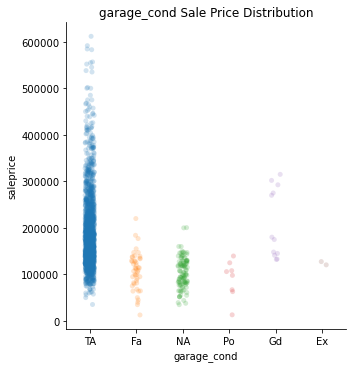

In [356]:
# plot it
sns.catplot(x = 'garage_cond', y='saleprice', data=train, alpha=0.2)\
    .set(title = 'garage_cond Sale Price Distribution');

In [357]:
# dummy to isEx,Gd,TA
train.garage_cond = train.garage_cond.map(lambda x: x == 'TA' or x == 'Gd' or x == 'Ex').astype(int)
test.garage_cond = test.garage_cond.map(lambda x: x == 'TA' or x == 'Gd' or x == 'Ex').astype(int)

train.rename(columns = {'garage_cond': 'garage_cond_Ex_Gd_TA'}, inplace = True)
test.rename(columns = {'garage_cond': 'garage_cond_Ex_Gd_TA'}, inplace = True)

train.iloc[[],26:36]

,fireplace_qu_Ex_Gd,garage_type_Attchd_BuiltIn,garage_cars,garage_area,garage_qual_Ex_Gd_TA,garage_cond_Ex_Gd_TA,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch
pid,,,,,,,,,,


#### review `paved`

In [358]:
train.paved_drive.value_counts(normalize=True)

Y    0.907308
N    0.073565
P    0.019127
Name: paved_drive, dtype: float64

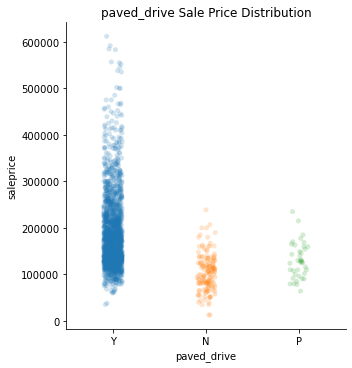

In [359]:
# plot it
sns.catplot(x = 'paved_drive', y='saleprice', data=train, alpha=0.2)\
    .set(title = 'paved_drive Sale Price Distribution');

In [360]:
# dummy to is_fully_paved_drive
train.paved_drive = train.paved_drive.map(lambda x: x == 'Y').astype(int)
test.paved_drive = test.paved_drive.map(lambda x: x == 'Y').astype(int)

train.rename(columns = {'paved_drive': 'is_fully_paved_drive'}, inplace = True)
test.rename(columns = {'paved_drive': 'is_fully_paved_drive'}, inplace = True)

train.iloc[[],26:36]

,fireplace_qu_Ex_Gd,garage_type_Attchd_BuiltIn,garage_cars,garage_area,garage_qual_Ex_Gd_TA,garage_cond_Ex_Gd_TA,is_fully_paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch
pid,,,,,,,,,,


**Observation** there are a lot of porch variables with sparse membership. Look into combining it into an overall porch variable

In [361]:
# create new variable for porch_sf
train['all_porch_sf'] = train.enclosed_porch + train.open_porch_sf + train.wood_deck_sf + train['3ssn_porch']+train.screen_porch
test['all_porch_sf'] = test.enclosed_porch + test.open_porch_sf + test.wood_deck_sf + test['3ssn_porch']+test.screen_porch

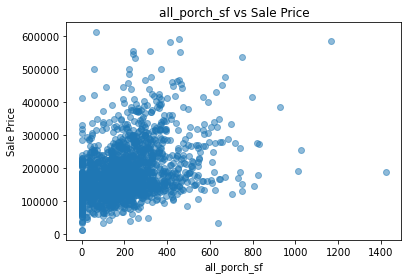

In [362]:
plt.scatter(x = train.all_porch_sf,
            y = train.saleprice,
            alpha = 0.5)
plt.title('all_porch_sf vs Sale Price')
plt.xlabel('all_porch_sf')
plt.ylabel('Sale Price');

In [363]:
train.all_porch_sf.describe()

count    2039.000000
mean      182.490927
std       158.980587
min         0.000000
25%        48.500000
50%       164.000000
75%       267.000000
max      1424.000000
Name: all_porch_sf, dtype: float64

**Observation** Positive correlation between `all_porch_sf` and `saleprice`

In [364]:
#create has porch
has_porch = train.all_porch_sf.map(lambda x: x > 0).astype(int).rename('has_porch')
test_has_porch = test.all_porch_sf.map(lambda x: x > 0).astype(int).rename('has_porch')

train['has_porch'] = has_porch
test['has_porch'] = test_has_porch

train.iloc[[],-5:]

,garage_finish_RFn,garage_finish_Unf,garage_finish_Fin,all_porch_sf,has_porch
pid,,,,,


In [365]:
# drop the porches
train.drop(['enclosed_porch','open_porch_sf','wood_deck_sf','3ssn_porch','screen_porch'],
           axis = 1,
           inplace = True)

test.drop(['enclosed_porch','open_porch_sf','wood_deck_sf','3ssn_porch','screen_porch'],
           axis = 1,
           inplace = True)

train.iloc[[],26:36]

,fireplace_qu_Ex_Gd,garage_type_Attchd_BuiltIn,garage_cars,garage_area,garage_qual_Ex_Gd_TA,garage_cond_Ex_Gd_TA,is_fully_paved_drive,pool_area,pool_qc,fence
pid,,,,,,,,,,


### Col [33:41]

In [366]:
train.columns[33:41]

Index(['pool_area', 'pool_qc', 'fence', 'misc_feature', 'misc_val', 'mo_sold',
       'yr_sold', 'sale_type'],
      dtype='object')

In [367]:
train.dtypes[33:41]

pool_area        int64
pool_qc         object
fence           object
misc_feature    object
misc_val         int64
mo_sold          int64
yr_sold          int64
sale_type       object
dtype: object

In [368]:
train.isnull().sum()[33:41]

pool_area          0
pool_qc         2031
fence           1640
misc_feature    1976
misc_val           0
mo_sold            0
yr_sold            0
sale_type          0
dtype: int64

In [369]:
test.isnull().sum()[33:41]

pool_area         0
pool_qc         874
fence           706
misc_feature    837
misc_val          0
mo_sold           0
yr_sold           0
sale_type         0
dtype: int64

#### investigate `pool_qc` nulls

In [370]:
train[train.pool_qc.isnull()].pool_area.value_counts()

0    2031
Name: pool_area, dtype: int64

In [371]:
# impute to 'NA'
train.pool_qc = train.pool_qc.map(lambda x: 'NA' if pd.isnull(x) else x)
test.pool_qc = test.pool_qc.map(lambda x: 'NA' if pd.isnull(x) else x)

#### investigate `fence` nulls

In [372]:
train.fence.unique()

array([nan, 'MnPrv', 'GdPrv', 'GdWo', 'MnWw'], dtype=object)

In [373]:
# impute to 'NA'
train.fence = train.fence.map(lambda x: 'NA' if pd.isnull(x) else x)
test.fence = test.fence.map(lambda x: 'NA' if pd.isnull(x) else x)

#### investigate `misc_feature` nulls

In [374]:
train[train.misc_feature.isnull()].misc_val.value_counts()

0    1976
Name: misc_val, dtype: int64

In [375]:
# impute to 'NA'
train.misc_feature = train.misc_feature.map(lambda x: 'NA' if pd.isnull(x) else x)
test.misc_feature = test.misc_feature.map(lambda x: 'NA' if pd.isnull(x) else x)

#### review `pool_area`

In [376]:
train.pool_area.value_counts(normalize=True)

0      0.996077
519    0.000490
576    0.000490
800    0.000490
228    0.000490
648    0.000490
738    0.000490
368    0.000490
561    0.000490
Name: pool_area, dtype: float64

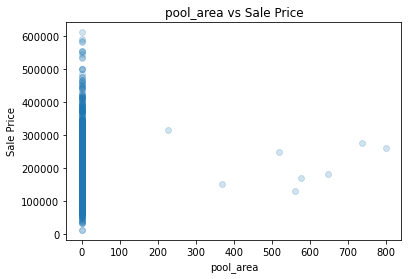

In [377]:
# plot it
plt.scatter(x = train.pool_area, y = train.saleprice, alpha = 0.2)
plt.title('pool_area vs Sale Price')
plt.xlabel('pool_area')
plt.ylabel('Sale Price');

In [378]:
# drop it
train.drop('pool_area', axis = 1, inplace=True)
test.drop('pool_area', axis = 1, inplace=True)

#### review `pool_qc`

In [379]:
train.pool_qc.value_counts(normalize=True)

NA    0.996077
Gd    0.001471
Fa    0.000981
TA    0.000981
Ex    0.000490
Name: pool_qc, dtype: float64

In [380]:
# drop it
train.drop('pool_qc', axis = 1, inplace=True)
test.drop('pool_qc', axis = 1, inplace=True)

#### review `fence`

In [381]:
train.fence.value_counts(normalize=True)

NA       0.804316
MnPrv    0.111329
GdPrv    0.040216
GdWo     0.039235
MnWw     0.004904
Name: fence, dtype: float64

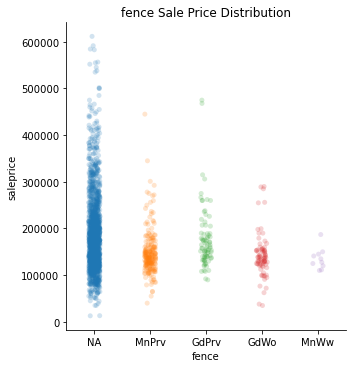

In [382]:
# plot
sns.catplot(x = 'fence', y='saleprice', data=train, alpha=0.2)\
    .set(title = 'fence Sale Price Distribution');

In [383]:
train.groupby('fence').mean().saleprice

fence
GdPrv    177358.878049
GdWo     141499.162500
MnPrv    147677.969163
MnWw     135165.000000
NA       188270.730488
Name: saleprice, dtype: float64

**Observation** NA slightly higher than all other fence types. Dummy it

In [384]:
# dummy has_fence
train.fence = train.fence.map(lambda x: x == 'NA').astype(int)
test.fence = test.fence.map(lambda x: x == 'NA').astype(int)


train.rename(columns = {'fence': 'has_fence'}, inplace = True)
test.rename(columns = {'fence': 'has_fence'}, inplace = True)

train.iloc[[],33:41]

,has_fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,ms_subclass_group_1
pid,,,,,,,,


#### review `misc_feature`

In [385]:
train.misc_feature.value_counts(normalize=True)

NA      0.969103
Shed    0.026974
Gar2    0.001962
Othr    0.001471
TenC    0.000490
Name: misc_feature, dtype: float64

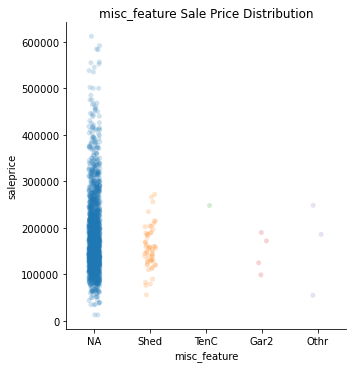

In [386]:
# plot it
sns.catplot(x = 'misc_feature', y='saleprice', data=train, alpha=0.2)\
    .set(title = 'misc_feature Sale Price Distribution');

In [387]:
# dummy it
train.misc_feature = train.misc_feature.map(lambda x: x == 'NA').astype(int)
test.misc_feature = test.misc_feature.map(lambda x: x == 'NA').astype(int)

train.rename(columns = {'misc_feature': 'has_misc_feature'}, inplace=True)
test.rename(columns = {'misc_feature': 'has_misc_feature'}, inplace=True)

train.iloc[[],33:41]

,has_fence,has_misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,ms_subclass_group_1
pid,,,,,,,,


#### review `misc_val`

In [388]:
train.misc_val.value_counts(normalize=True)

0        0.969103
400      0.005885
500      0.003433
600      0.002943
450      0.002452
2000     0.002452
700      0.001962
1200     0.000981
2500     0.000981
3000     0.000981
4500     0.000981
1300     0.000490
1150     0.000490
1500     0.000490
800      0.000490
6500     0.000490
54       0.000490
900      0.000490
460      0.000490
300      0.000490
455      0.000490
8300     0.000490
3500     0.000490
12500    0.000490
480      0.000490
650      0.000490
80       0.000490
Name: misc_val, dtype: float64

In [389]:
# drop it
train.drop('misc_val', axis = 1, inplace=True)
test.drop('misc_val', axis = 1, inplace=True)

#### review `mo_sold` & `yr_sold`

In [390]:
train.mo_sold.value_counts(normalize=True)

6     0.171653
7     0.148112
5     0.126042
4     0.102011
3     0.081412
8     0.081412
10    0.058852
9     0.052967
2     0.051005
11    0.050025
1     0.038254
12    0.038254
Name: mo_sold, dtype: float64

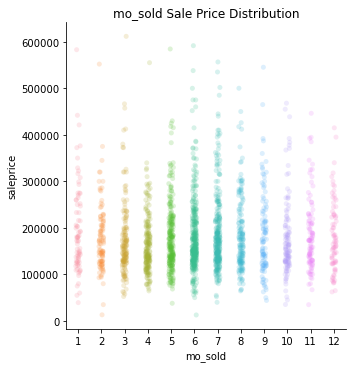

In [391]:
# plot it
sns.catplot(x = 'mo_sold', y='saleprice', data=train, alpha=0.2)\
    .set(title = 'mo_sold Sale Price Distribution');

In [392]:
# maybe link with yr sold
# review with yr sold
train.yr_sold.value_counts(normalize=True)

2007    0.242766
2009    0.216282
2006    0.214811
2008    0.211378
2010    0.114762
Name: yr_sold, dtype: float64

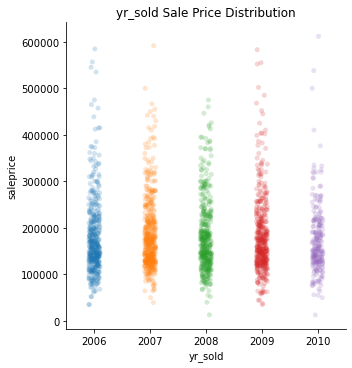

In [393]:
# plot it
sns.catplot(x = 'yr_sold', y='saleprice', data=train, alpha=0.2)\
    .set(title = 'yr_sold Sale Price Distribution');

In [394]:
train.groupby('yr_sold').mean().saleprice

yr_sold
2006    179471.609589
2007    185107.793939
2008    181505.364269
2009    182036.369615
2010    174180.059829
Name: saleprice, dtype: float64

In [395]:
train.groupby('mo_sold').mean().saleprice

mo_sold
1     195576.641026
2     177626.519231
3     174573.078313
4     163901.269231
5     180332.369650
6     182052.300000
7     188253.208609
8     186848.608434
9     189389.750000
10    177794.083333
11    183812.568627
12    182459.615385
Name: saleprice, dtype: float64

In [396]:
# group into premium months
sold_premium_month = train.mo_sold.map(train.groupby('mo_sold').mean().saleprice > saleprice_mean).astype(int)
test_sold_premium_month = test.mo_sold.map(train.groupby('mo_sold').mean().saleprice > saleprice_mean).astype(int)

train['sold_premium_month']= sold_premium_month
test['sold_premium_month']= test_sold_premium_month

In [397]:
# dummy years
yr_sold_dummies = pd.get_dummies(train.yr_sold, prefix = 'yr_sold')\
                  .loc[:,['yr_sold_2006','yr_sold_2007','yr_sold_2008','yr_sold_2009']]

test_yr_sold_dummies = pd.get_dummies(test.yr_sold, prefix = 'yr_sold')\
                  .loc[:,['yr_sold_2006','yr_sold_2007','yr_sold_2008','yr_sold_2009']]

train = train.join(yr_sold_dummies)
test = test.join(test_yr_sold_dummies)

In [398]:
# drop year and month
train.drop(['mo_sold','yr_sold'],
           axis = 1,
           inplace=True)

test.drop(['mo_sold','yr_sold'],
           axis = 1,
           inplace=True)

train.iloc[[],33:41]

,has_fence,has_misc_feature,sale_type,saleprice,ms_subclass_group_1,ms_subclass_group_2,ms_zoning_RL,ms_zoning_FV
pid,,,,,,,,


#### review `sale_type`

In [399]:
train.sale_type.value_counts(normalize=True)

WD       0.868563
New      0.077489
COD      0.030897
ConLD    0.008337
CWD      0.004904
ConLI    0.003433
ConLw    0.002452
Con      0.001962
Oth      0.001962
Name: sale_type, dtype: float64

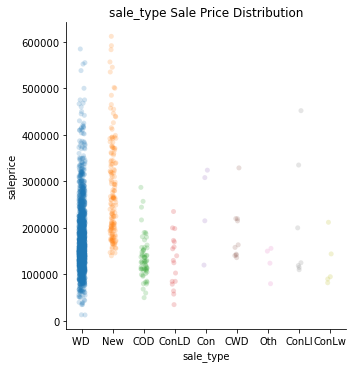

In [400]:
#plot it
sns.catplot(x = 'sale_type', y='saleprice', data=train, alpha=0.2)\
    .set(title = 'sale_type Sale Price Distribution');

In [401]:
train.groupby('sale_type').mean().saleprice

sale_type
COD      133574.523810
CWD      186635.000000
Con      241807.500000
ConLD    129091.352941
ConLI    207992.857143
ConLw    124600.000000
New      280376.702532
Oth      127497.750000
WD       174573.754941
Name: saleprice, dtype: float64

In [402]:
# dummy to is WD and is New
sale_type_WD = train.sale_type.map(lambda x: x == 'WD').astype(int).rename('sale_type_WD')
sale_type_New = train.sale_type.map(lambda x: x == 'New').astype(int).rename('sale_type_New')

test_sale_type_WD = test.sale_type.map(lambda x: x == 'WD').astype(int).rename('sale_type_WD')
test_sale_type_New = test.sale_type.map(lambda x: x == 'New').astype(int).rename('sale_type_New')

train = train.join([sale_type_WD,sale_type_New])
test = test.join([test_sale_type_WD,test_sale_type_New])

train.iloc[[],-5:]

,yr_sold_2007,yr_sold_2008,yr_sold_2009,sale_type_WD,sale_type_New
pid,,,,,


In [403]:
# drop sale_type
train.drop('sale_type', axis=1, inplace=True)
test.drop('sale_type', axis=1, inplace=True)


train.iloc[[],33:41]

,has_fence,has_misc_feature,saleprice,ms_subclass_group_1,ms_subclass_group_2,ms_zoning_RL,ms_zoning_FV,lot_config_Inside
pid,,,,,,,,


# Save and Export files

In [404]:
train.to_csv('datasets/train_cleaned.csv')
test.to_csv('datasets/test_cleaned.csv')